# $R_t$ MCMC
For this experiment, we assume a functional form for the time-varying reproduction number
$$
R_t=R^{\text {before }}+\frac{R^{a f t e r}-R^{b e f o r e}}{1+e^{-k(t-m)}}
$$
and then generate synthetic data using specified parameters of $\left(R^{b e f o r e}, R^{a f t e r}, k, m\right)$ to generate a epidemic curve using a Poisson process (with the adding additional Gaussian noise).

We then use a Bayesian MCMC approach to infer our 4 parameters using priors
- $R^{\text {before }} \sim U\left(a_{\text {before }}, b_{b e f o r e}\right)$
- $R^{a f t e r} \sim U\left(a_{a f t e r}, b_{a f t e r}\right)$
- $k \sim U(a, b)$
- $m \sim U\left(0, n_t\right)$

and likelihood

- $\operatorname{Pr}\left(\hat{i}_t \mid i_t, \theta\right) \sim \operatorname{StudentT}\left(\operatorname{df} = \nu, \mu=i_t, \sigma=\sigma \sqrt{i_t}\right) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)}\left(\frac{1}{\sigma^2 \pi \nu}\right)^{\frac{1}{2}}\left[1+\frac{(x-\mu)^2}{\sigma^2\nu}\right]^{-\frac{\nu+1}{2}}$

where $\hat{i}_t$ is the estimate daily reported cases, $i_t$ is the daily reported cases from our synthetic data, and the current sample $\theta=\left\{R^{b e f o r e}, R^{a f t e r}, k, m\right\}$.

## Simulate Data

In [1]:
%matplotlib inline

import pymc as pm
print(f"pyMC version: {pm.__version__}")

import numpy as np
import pandas as pd

import arviz as az
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

import logging

import pytensor
import pytensor.tensor as pt
from pytensor import scan
# pytensor.config.floatX = "float64"

from datetime import date
import os

pyMC version: 5.0.2


In [2]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

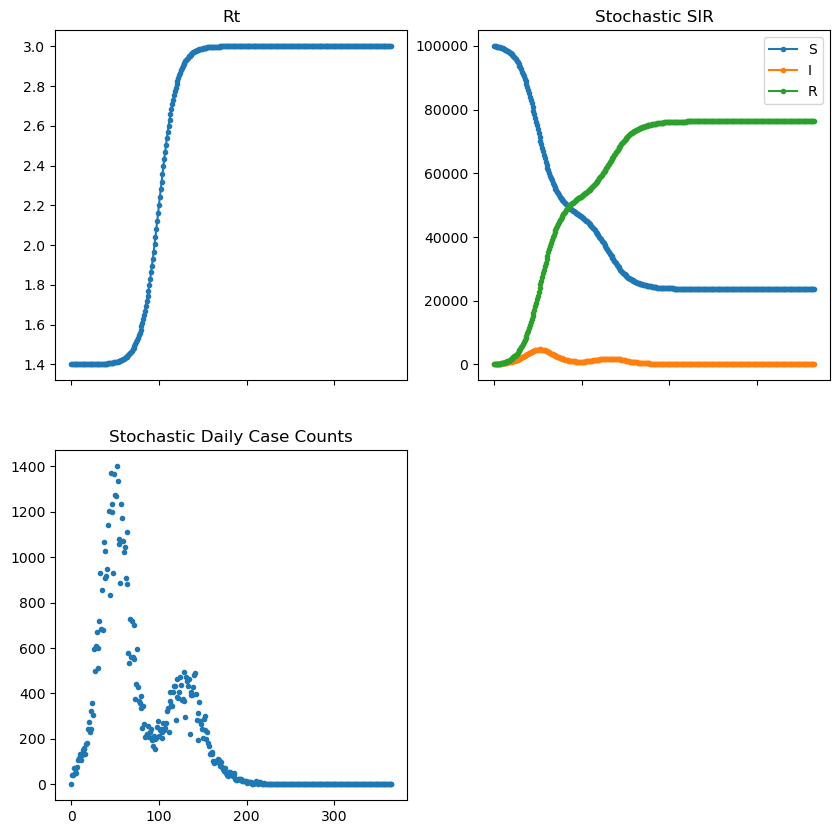

In [6]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}

np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()

In [7]:
# simulate_data.simulate_data(**true_params, add_noise=False).plot_all(path=None)

## Model

In [49]:
import model
importlib.reload(model)

sir_model = model.SIR_model(data)

likelihood = {
    # 'dist': 'students-t', 
    # 'nu': 4,
    # 'sigma': 0.2,
    # 'min_sigma': 10,
    'dist': 'normal',
    # 'sigma': 0.2,
    # 'min_sigma': 10,
    # 'dist': 'negbin',
}
prior = {
    'rt_0':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['rt_0'],
        # }
        'dist': pm.Uniform,
        'args':{
        'lower': 1.,
        'upper': 4.,
        }
    },
    'rt_1':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['rt_1'],
        # }
        'dist': pm.Uniform,
        'args': {
            'lower': 1.5,
            'upper': 4.,
        }
    },
    'k':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['k'],
        # }
        'dist': pm.Uniform,
        'args': {
            'lower': 0.01,
            'upper': 2,
        }
    },
    'midpoint':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['midpoint'],
        # }
        'dist': pm.Uniform,
        'args': {
            'lower': 30,
            'upper': 200,
        }
    },
    'I0':{
        # 'dist': pm.Poisson,
        'dist': pm.Uniform,
        'args': {
            # 'mu': 50,
            'lower': 70,
            'upper': 200
        }
    },
}

method = 'DEmetropolis'
n_samples = 50000
n_tune = 10000

vars = []
for k,v in prior.items():
    if v['dist'] != "constant":
        vars.append(k)

today = date.today() 
name = f"{method}_likelihood_{likelihood['dist']}"
path = os.path.abspath(f'../data/{today}_{name}')

print(name)

DEmetropolis_likelihood_normal


In [50]:
sir_model.run_SIR_model(n_samples=n_samples, n_tune=n_tune, likelihood=likelihood, prior=prior, method=method, path=path)

Population sampling (9 chains)
DEMetropolis: [rt_0, rt_1, k, midpoint, I0, sigma]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.


/opt/anaconda3/envs/rt-estimation/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:827: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 9 chains for 0 tune and 60_000 draw iterations (0 + 540_000 draws total) took 9814 seconds.


Sampling: [I0, i_est, k, midpoint, rt_0, rt_1, sigma]
Sampling: [i_est]


In [51]:
summary_df, acc_rate = sir_model.sample_stats(vars)
display(summary_df)
display(acc_rate)

UnboundLocalError: local variable 'acc_rate' referenced before assignment

In [52]:
az.plot_energy(sir_model.trace)

AttributeError: 'Dataset' object has no attribute 'energy'

In [53]:
sir_model.trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Make and Save Plots

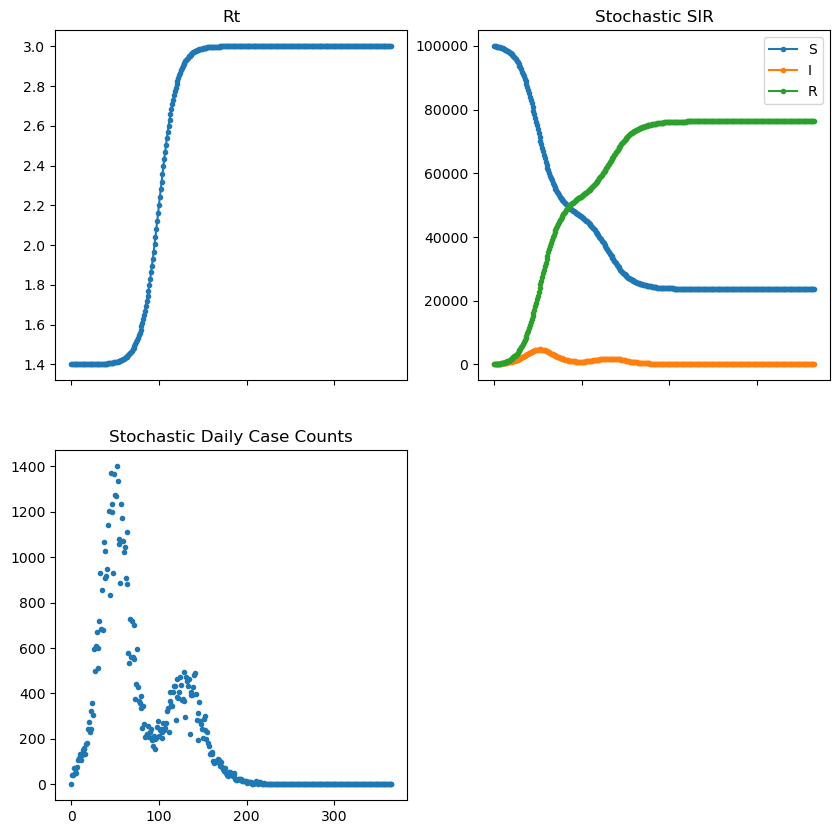

In [54]:
data.plot_all(path)

Percent of observations in 95% CI 0.9972602739726028
Percent of observations in 50% CI 0.7452054794520548


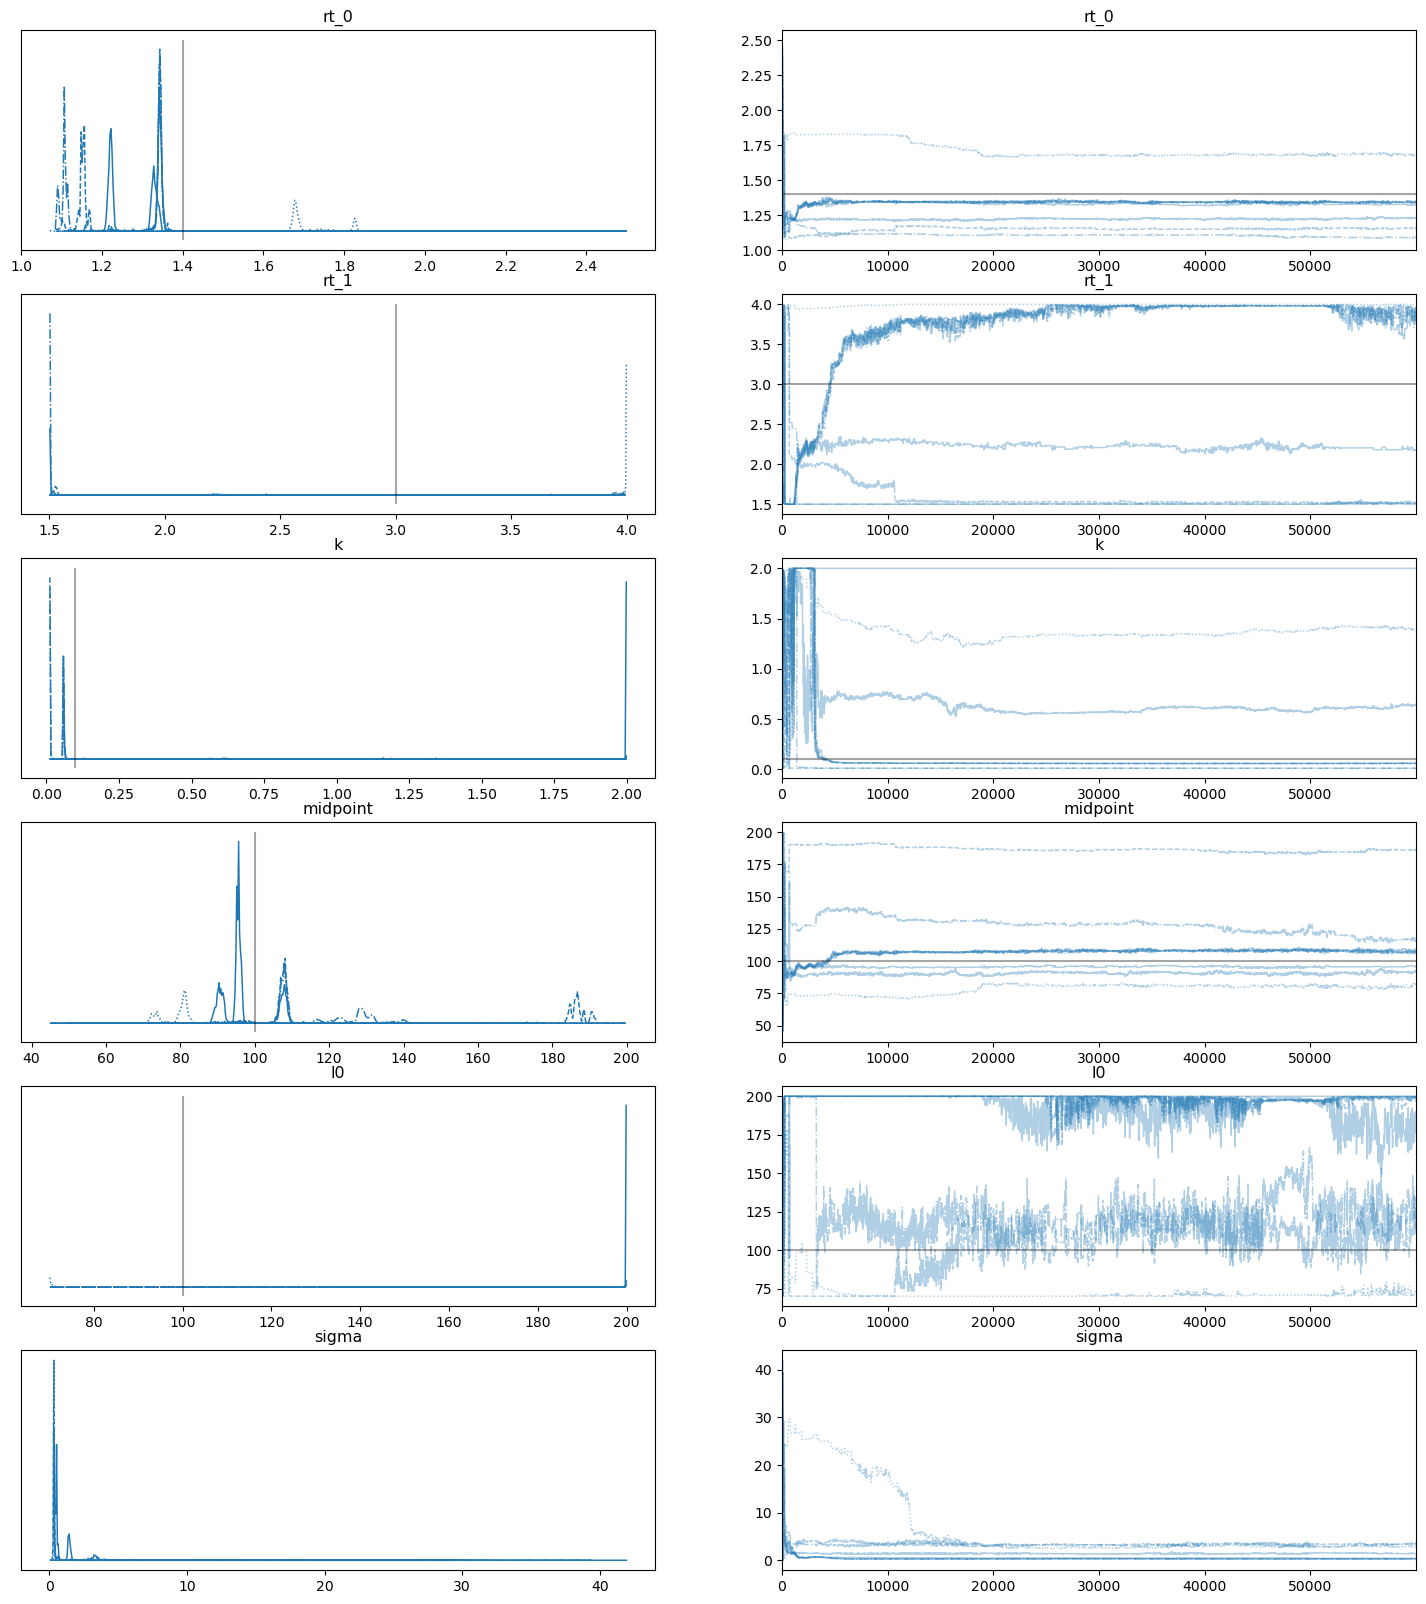

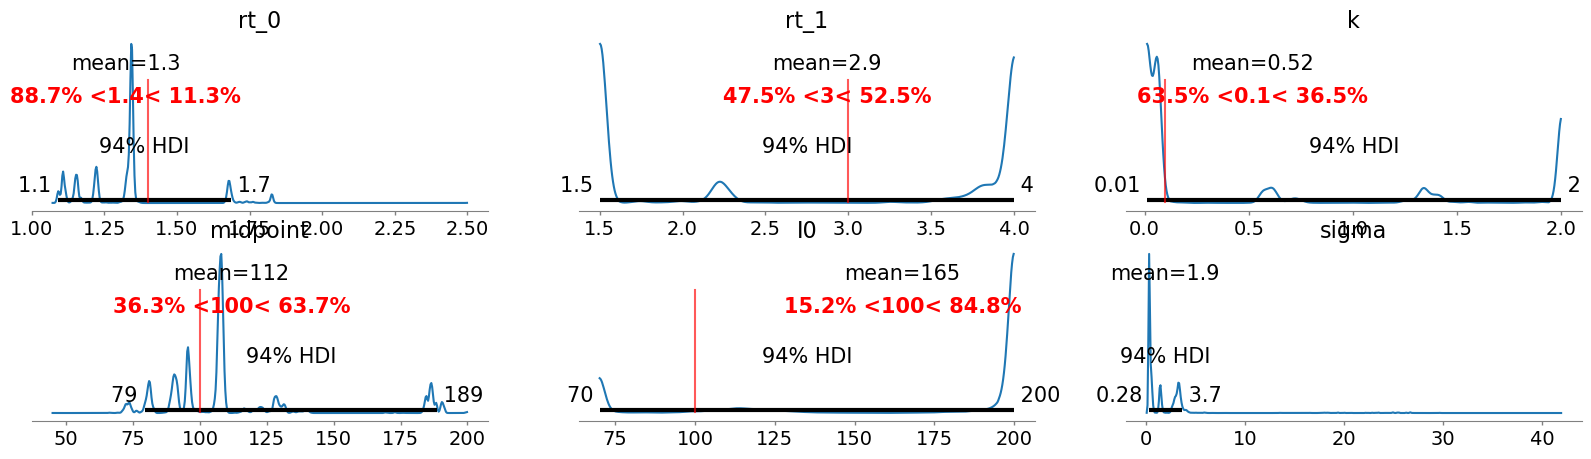

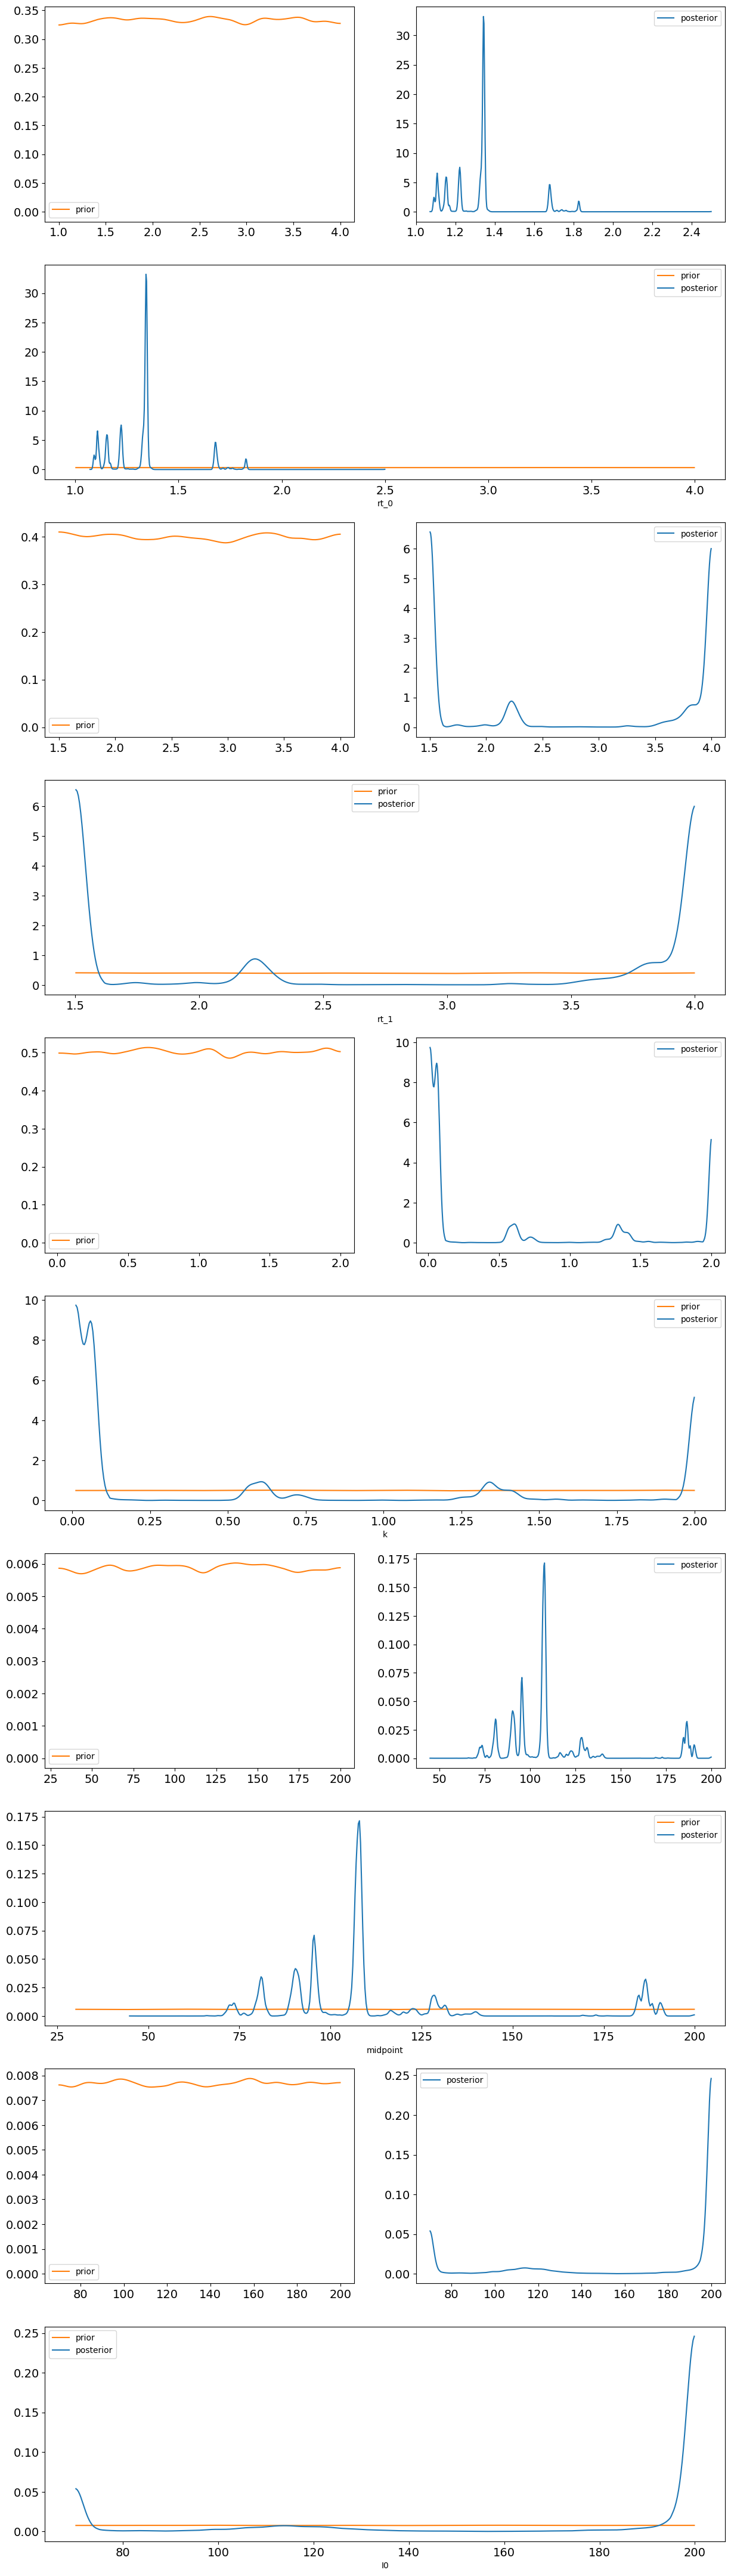

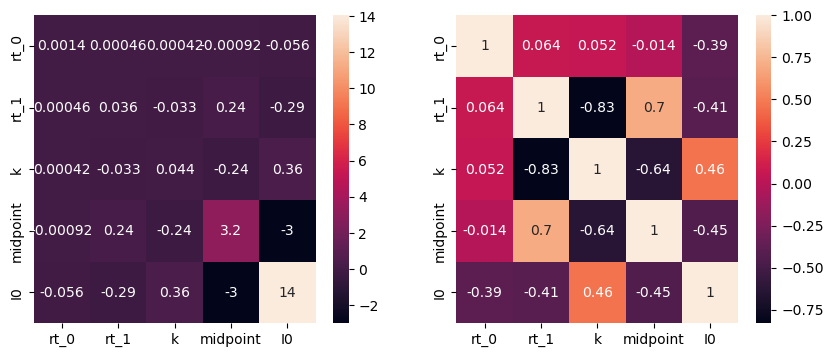

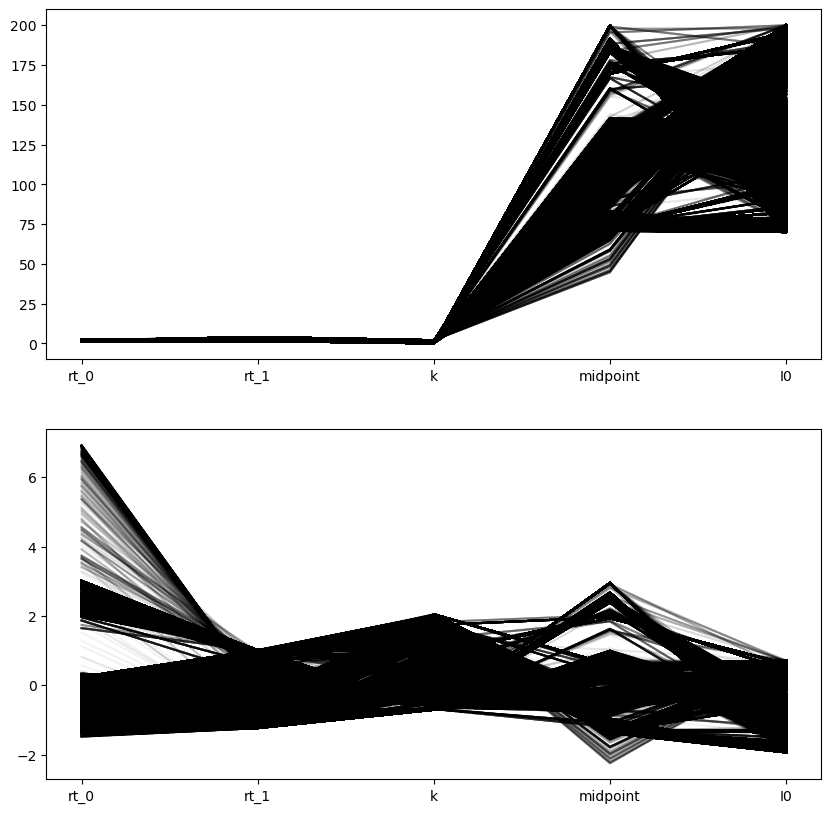

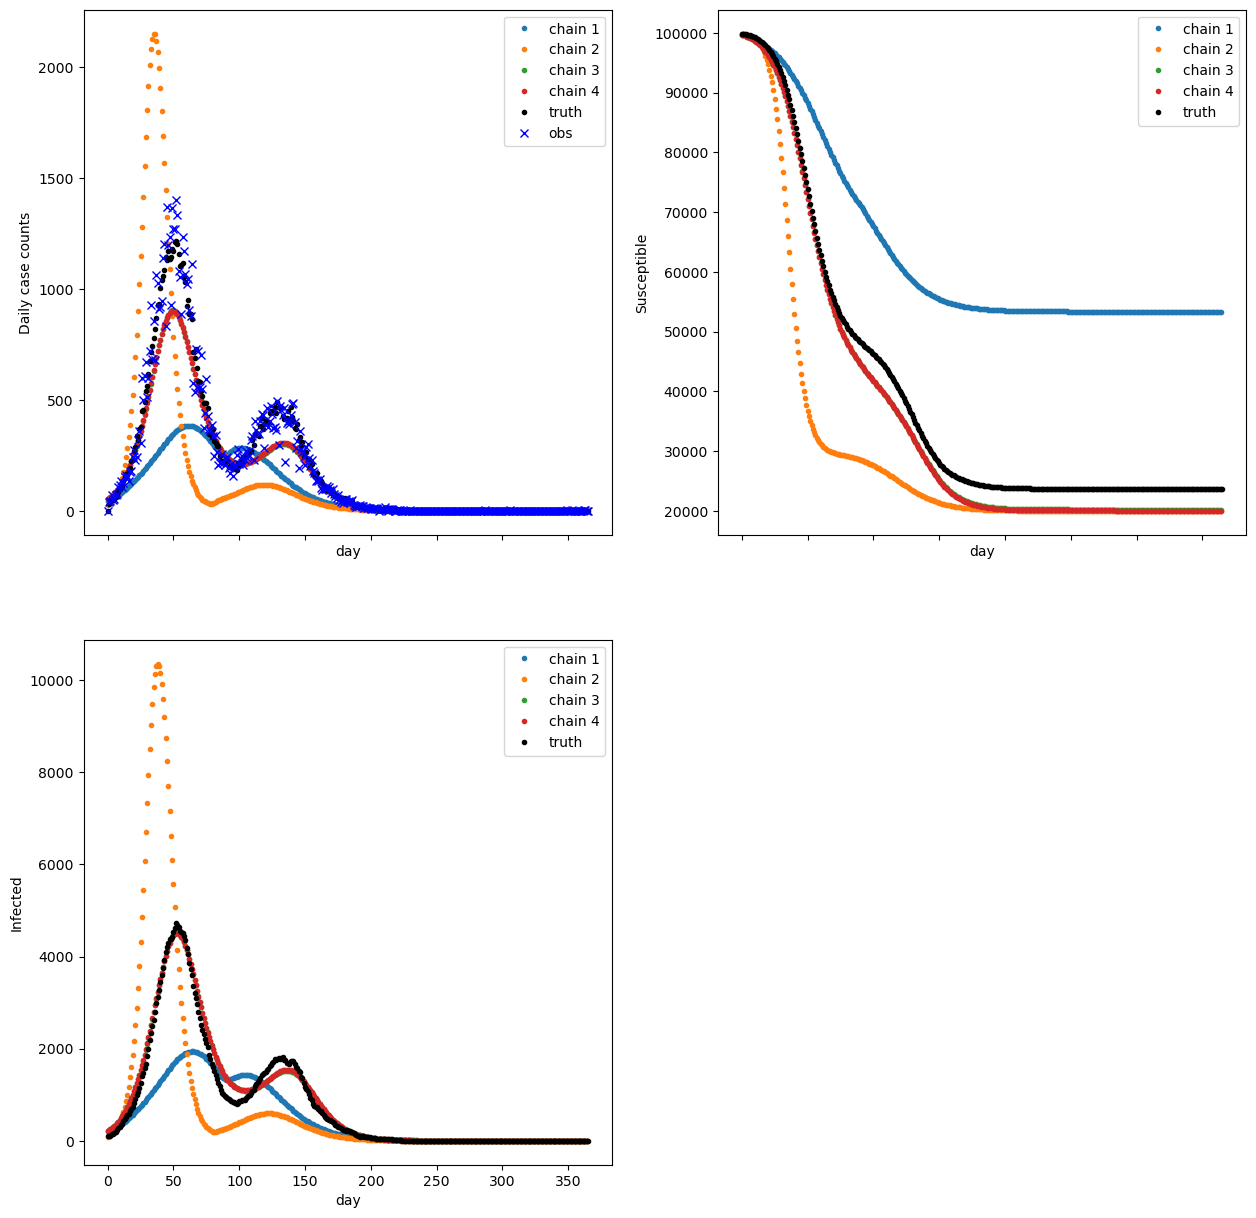

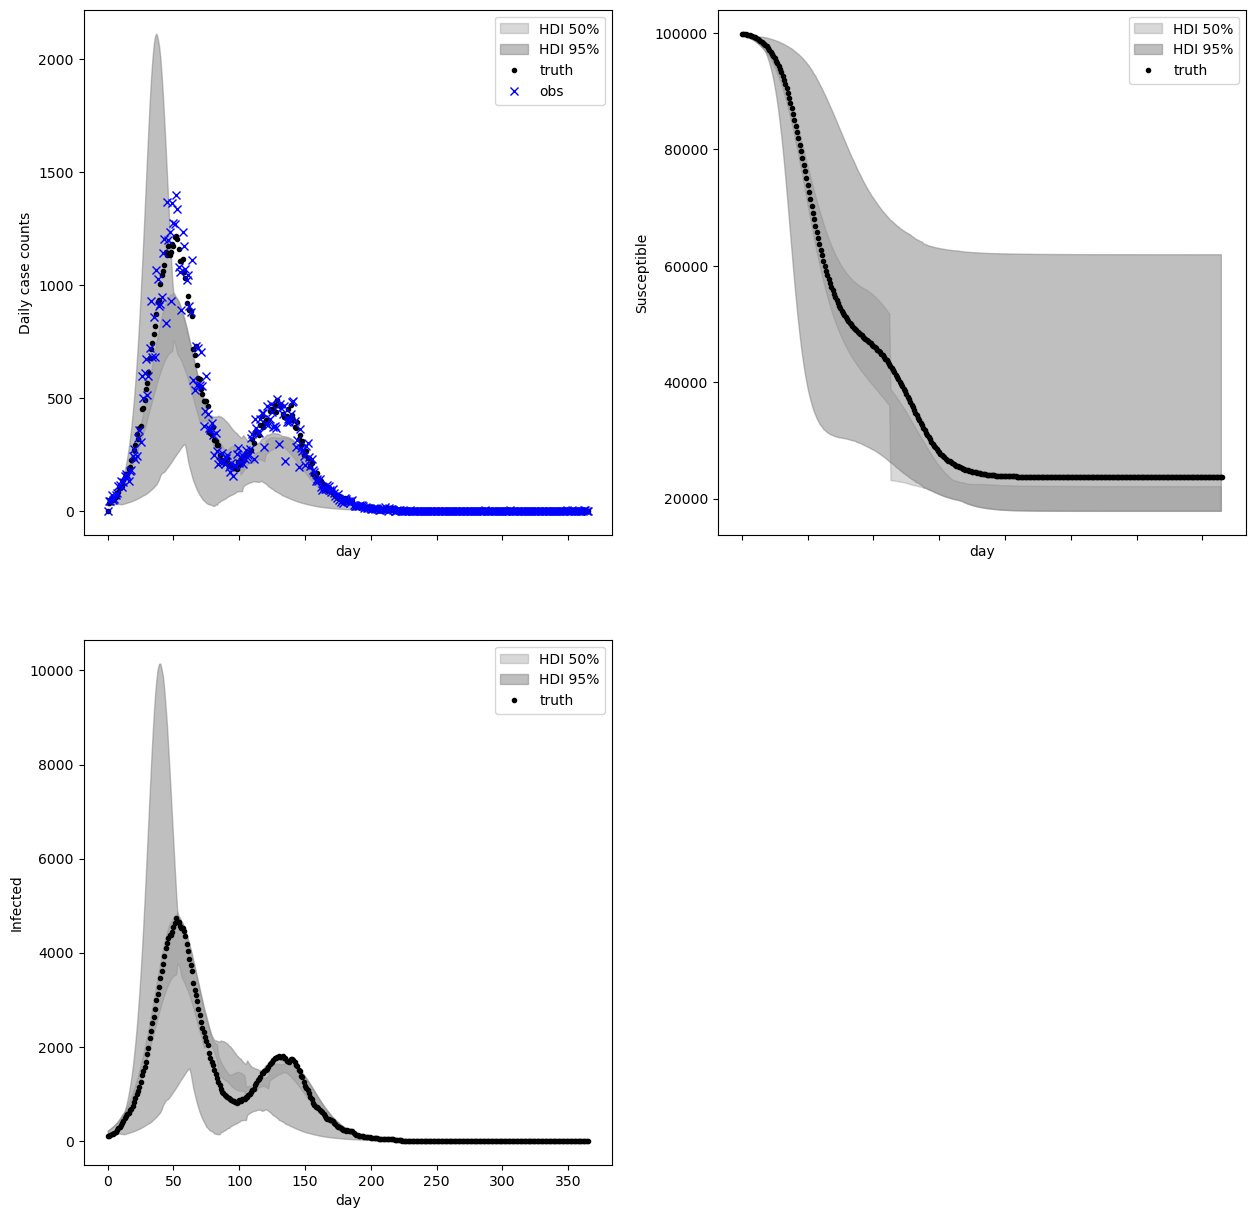

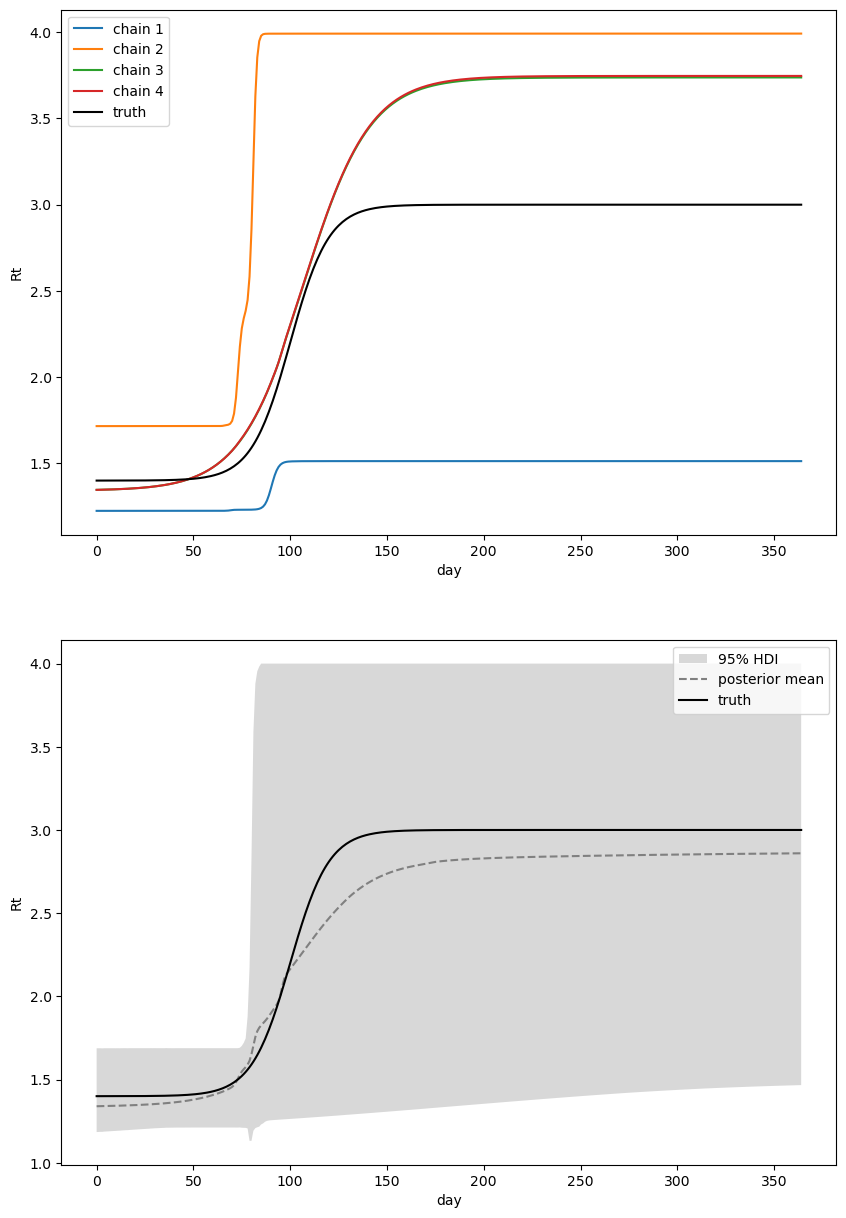

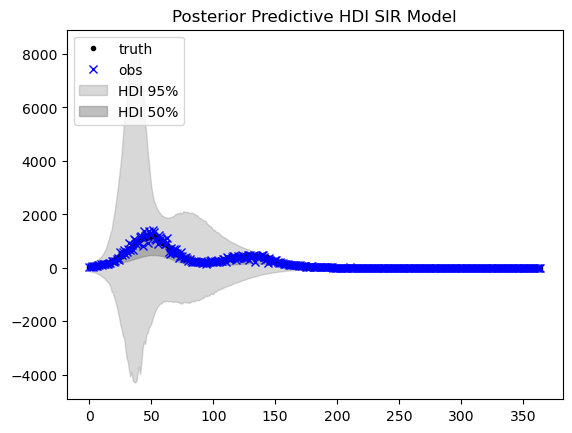

In [58]:
sir_model.plot_all(vars, path)

/opt/anaconda3/envs/rt-estimation/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'i'}>,
        <AxesSubplot: title={'center': 'i'}>]], dtype=object)

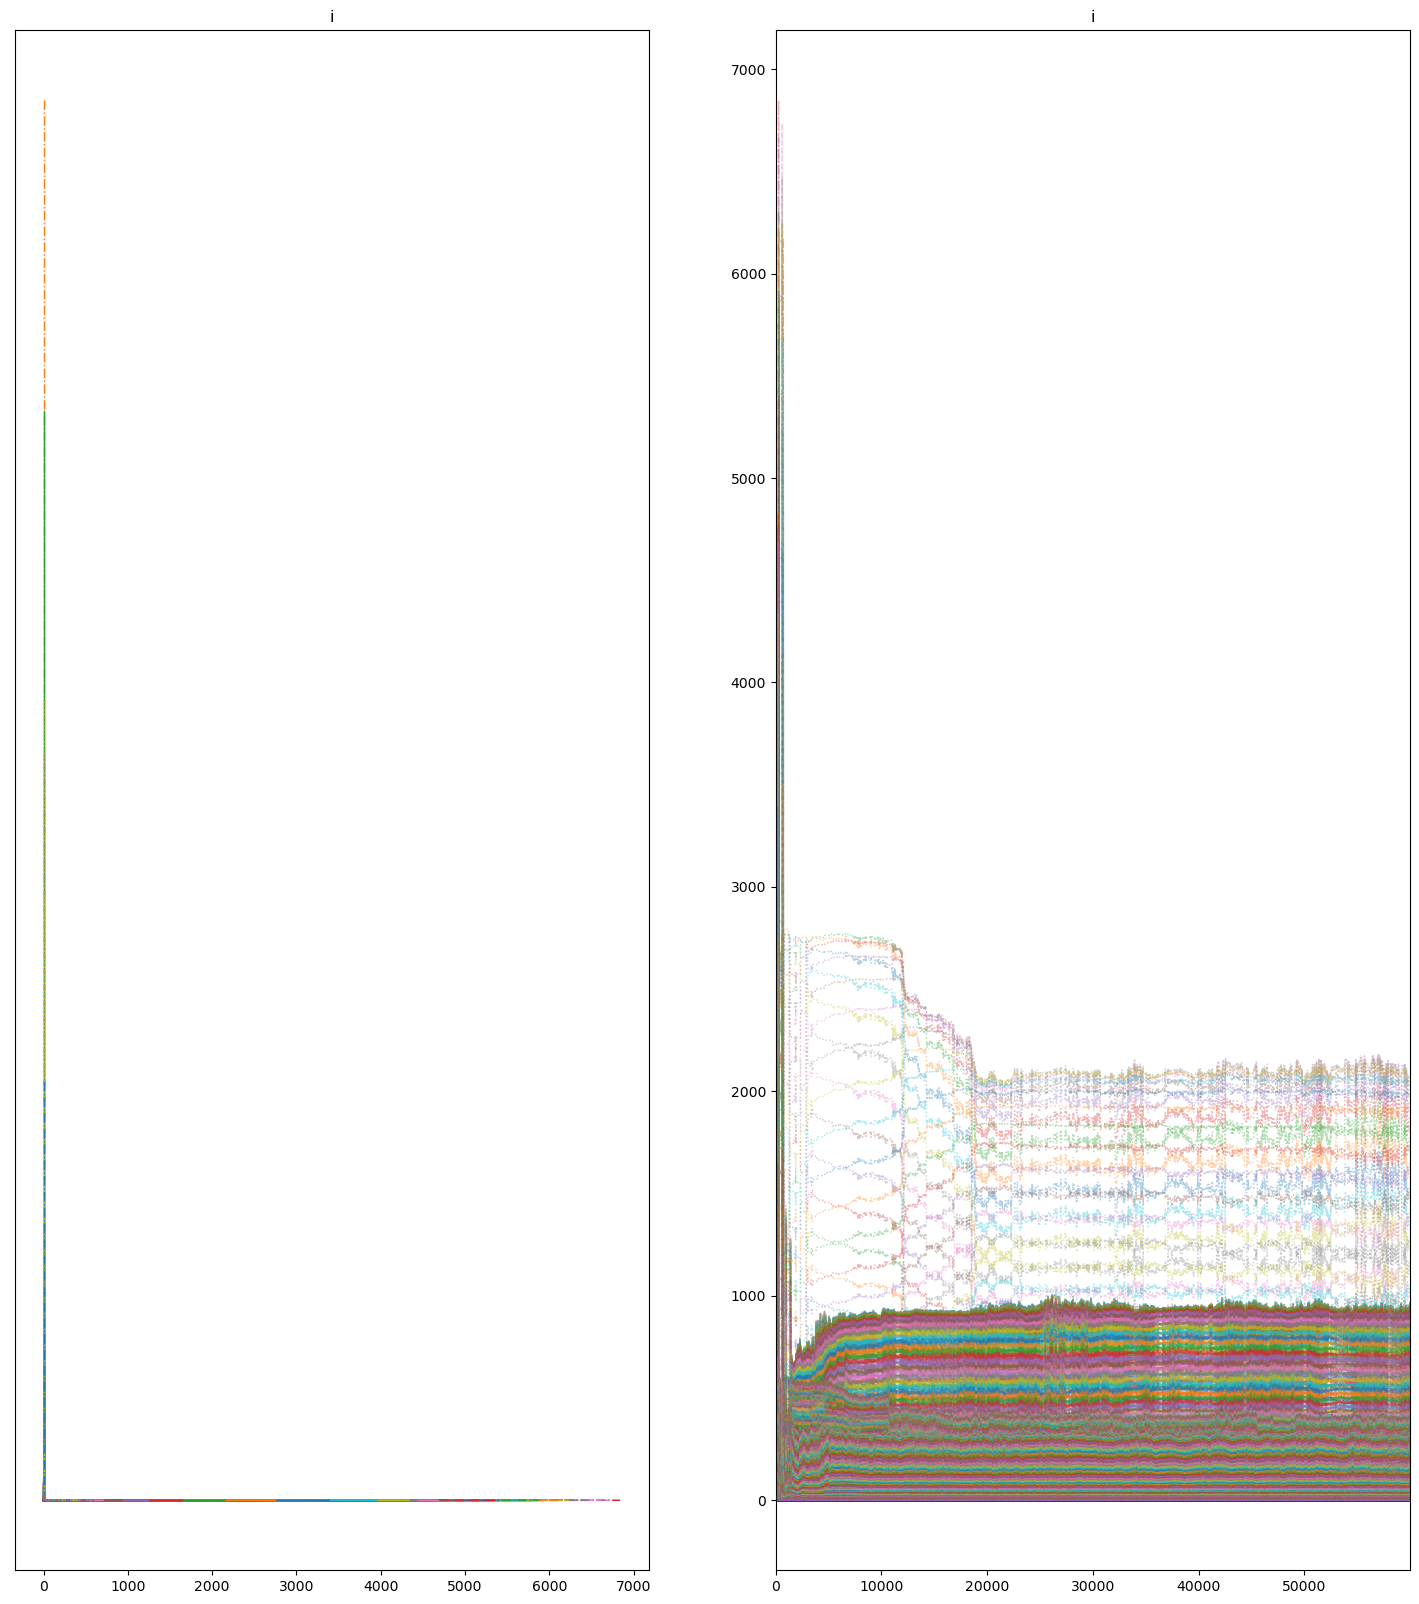

In [59]:
az.plot_trace(sir_model.trace, var_names=["i"],figsize=(18, 20))

In [60]:
# Save Trace and Model
data.save_data(path)
sir_model.save_model(path)

### Change point detection

rbf
0


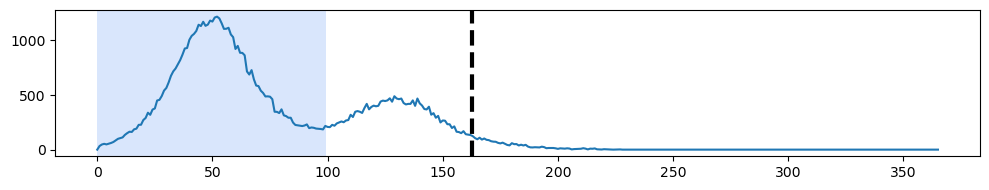

linear
0


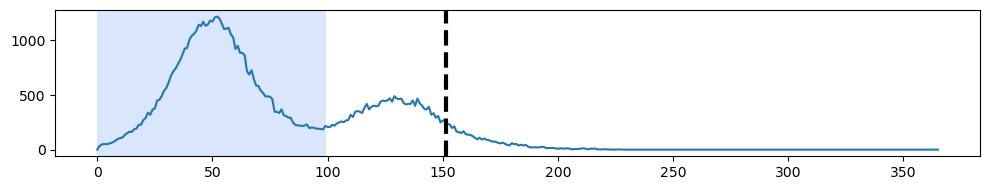

cosine
0


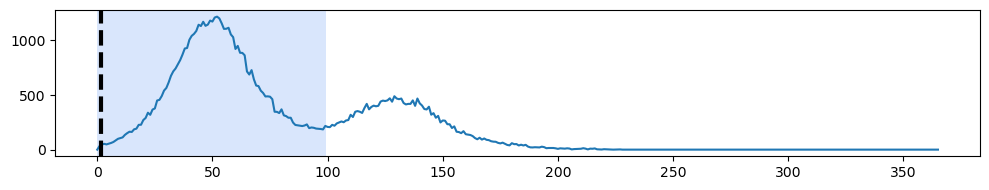

rbf
1


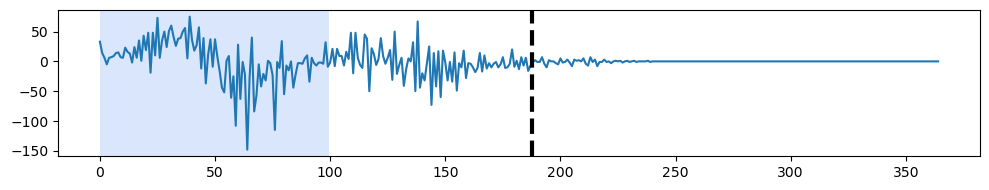

linear
1


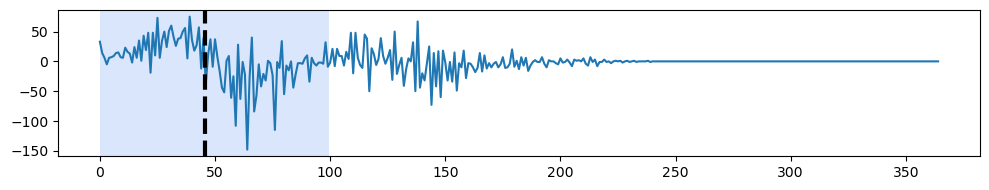

cosine
1


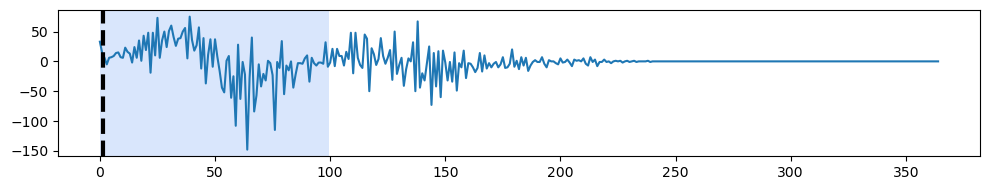

rbf
2


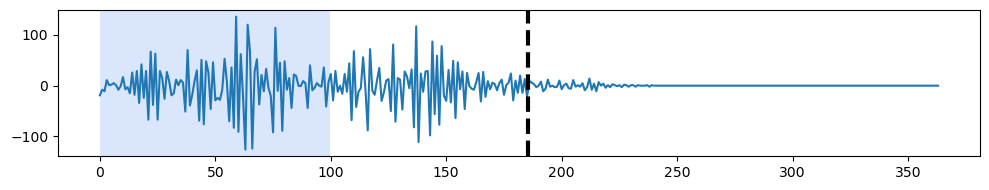

linear
2


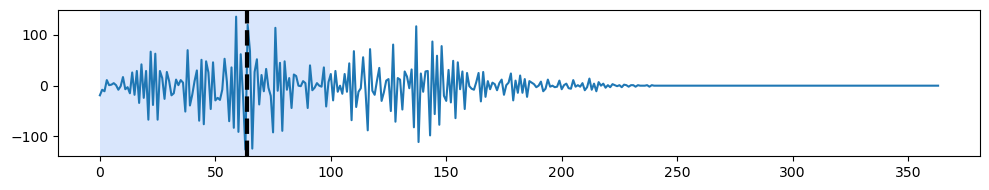

cosine
2


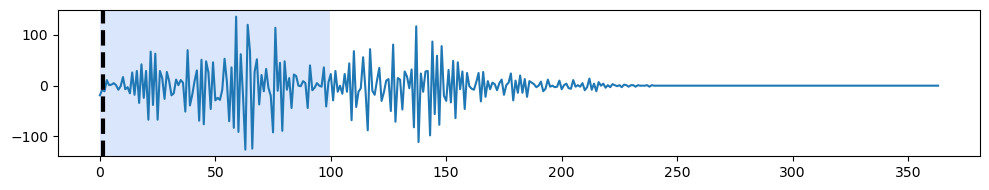

rbf
3


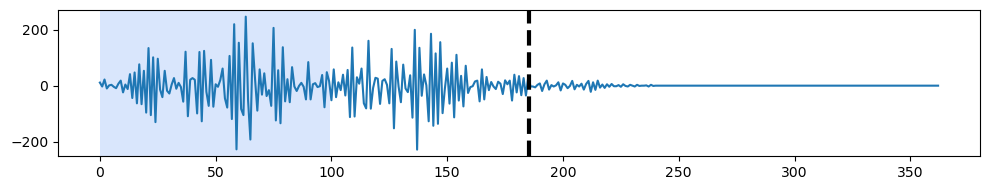

linear
3


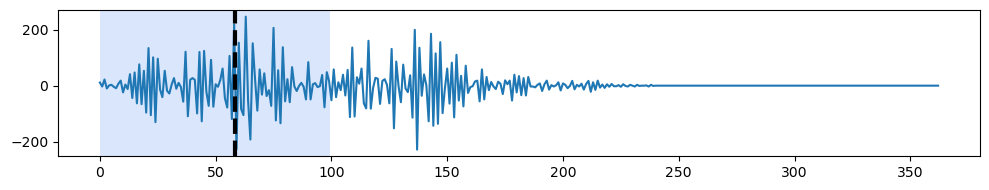

cosine
3


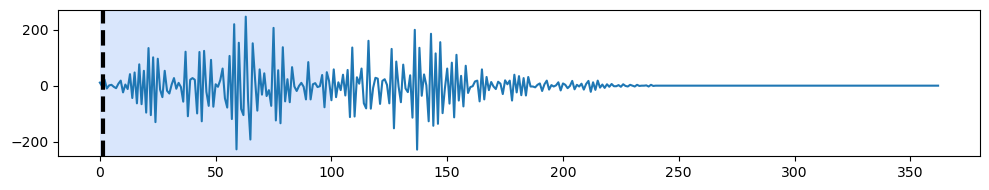

rbf
4


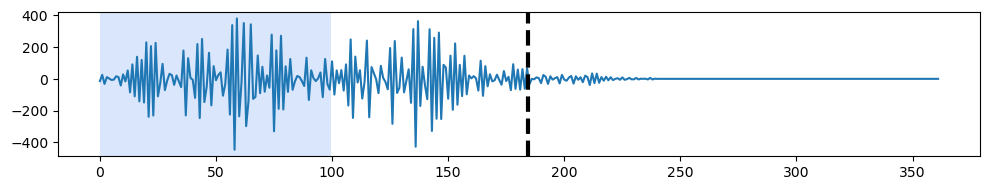

linear
4


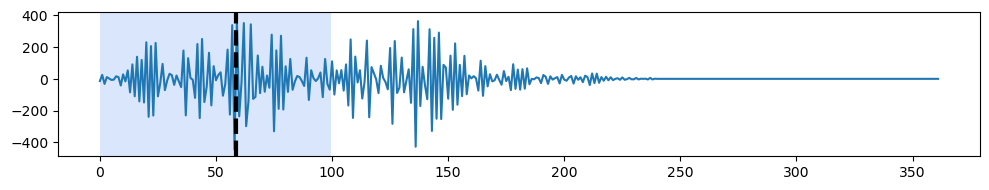

cosine
4


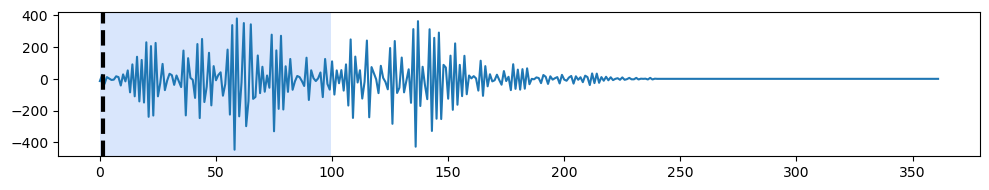

In [262]:
import ruptures as rpt

bkps = [midpoint]

kernels = ["rbf", "linear", "cosine"]

for n in range(5):
    for k in kernels:
        print(k)
        print(n)
        algo = rpt.KernelCPD(kernel=k).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l1
0


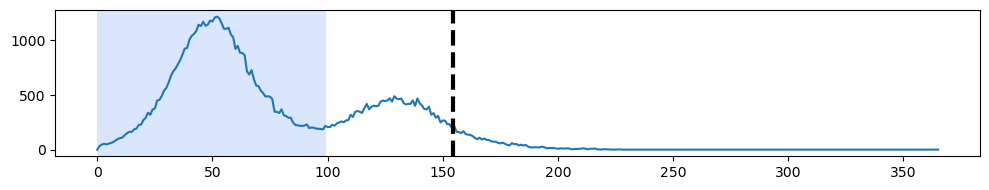

l2
0


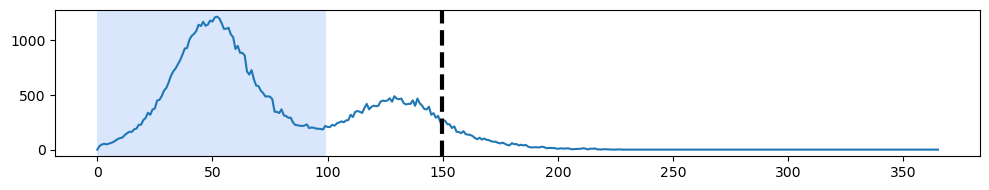

rbf
0


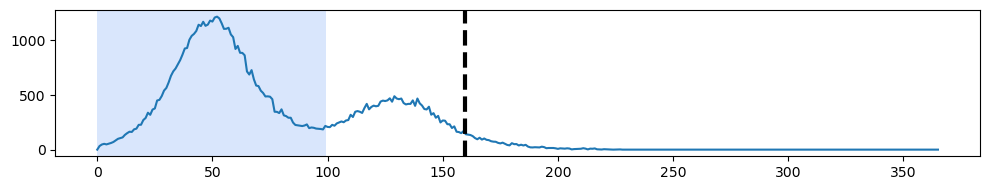

l1
1


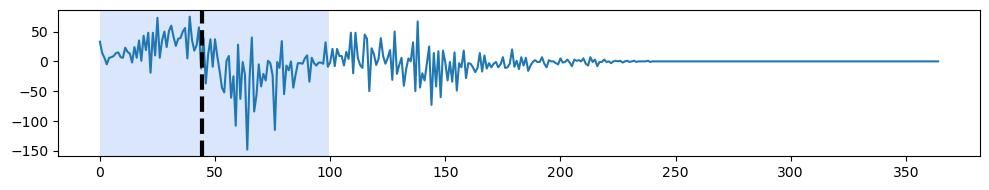

l2
1


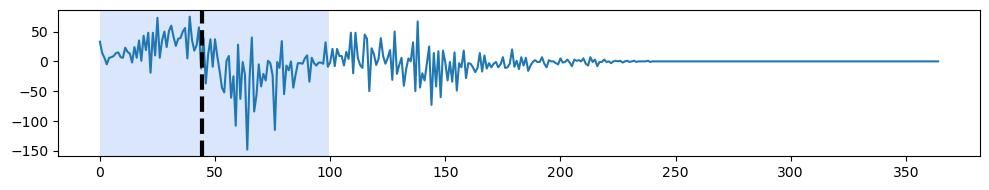

rbf
1


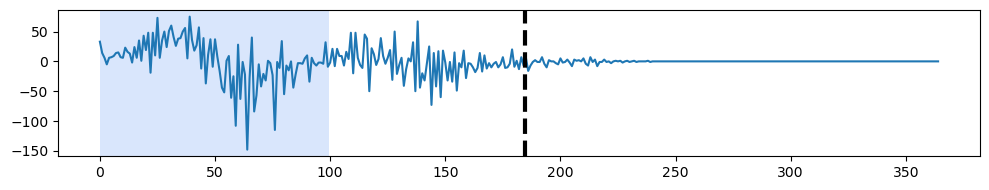

l1
2


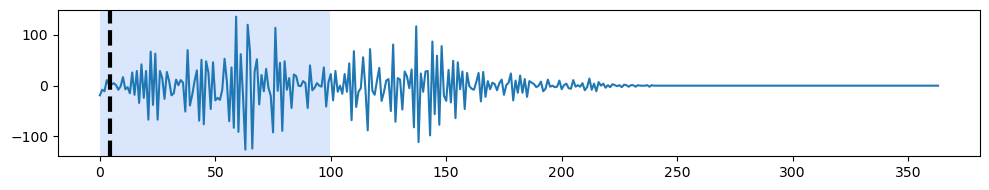

l2
2


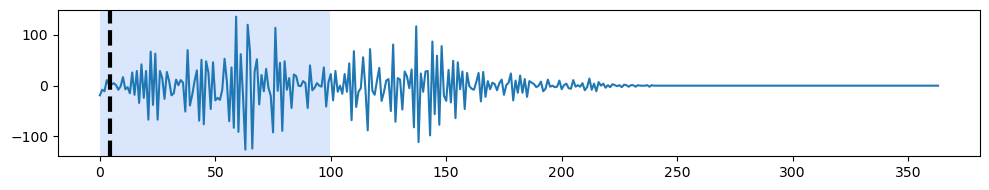

rbf
2


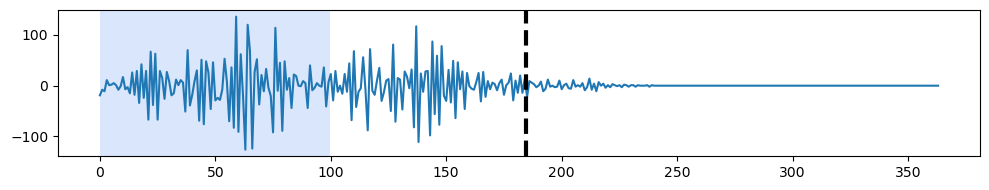

l1
3


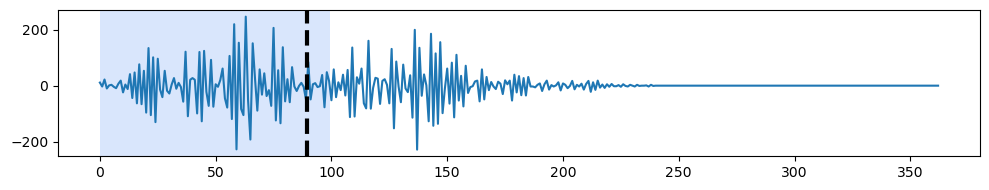

l2
3


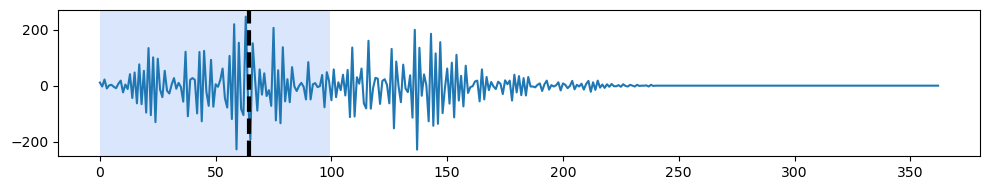

rbf
3


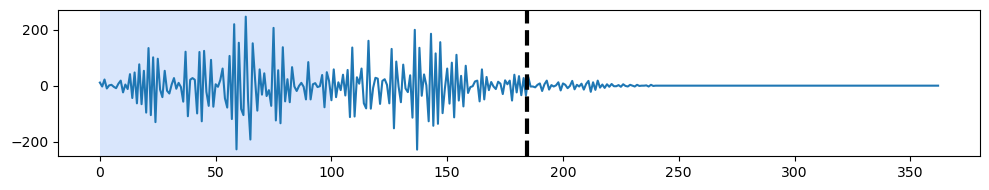

l1
4


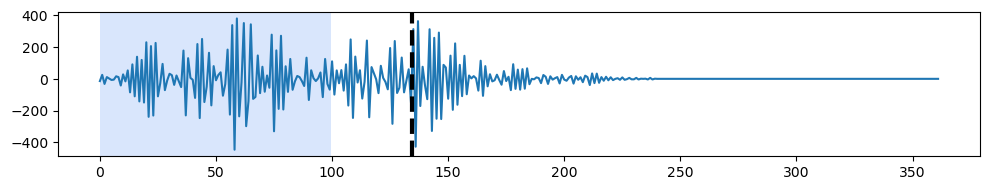

l2
4


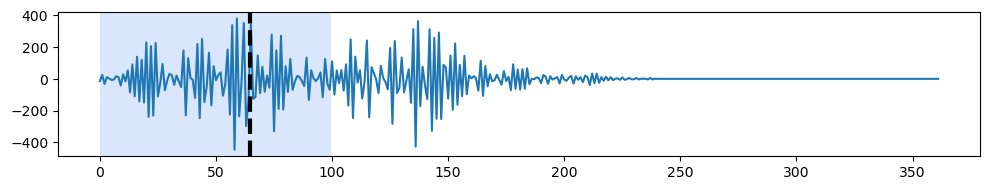

rbf
4


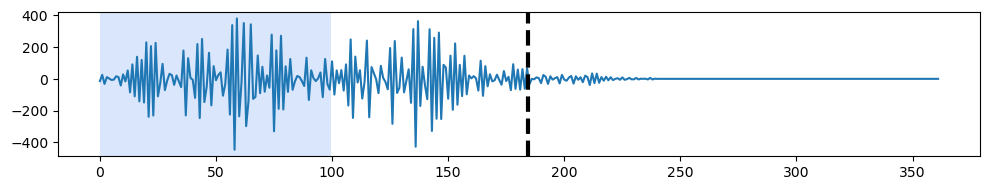

In [263]:
models = ["l1", "l2", "rbf"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Dynp(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l1
0


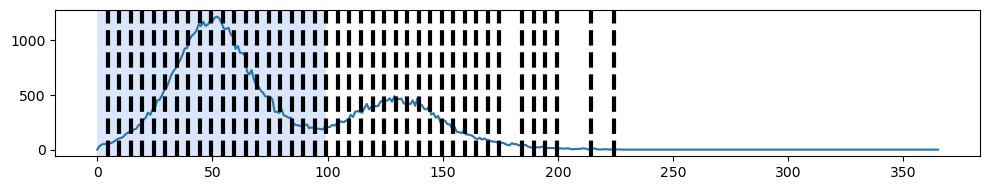

l2
0


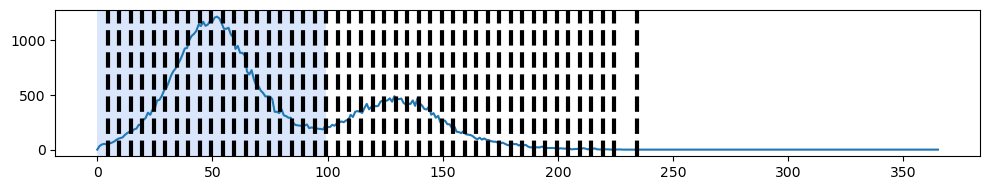

rbf
0


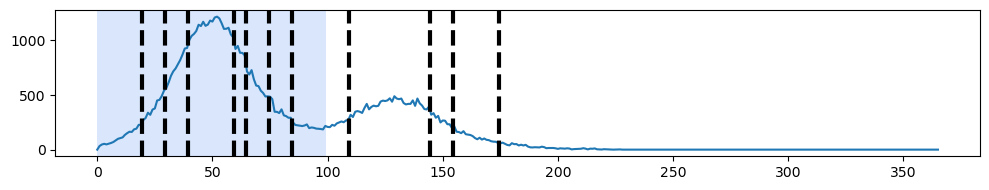

l1
1


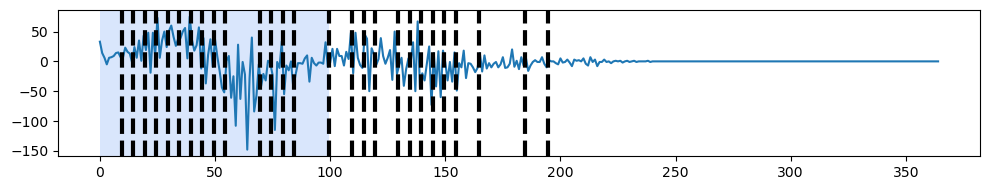

l2
1


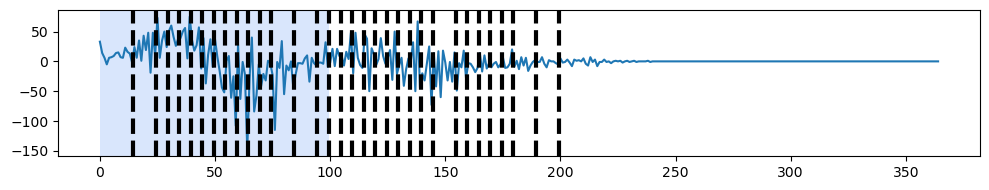

rbf
1


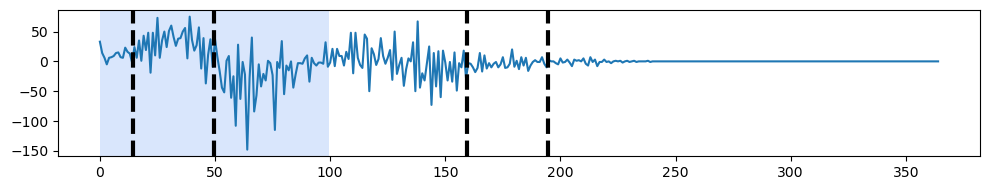

l1
2


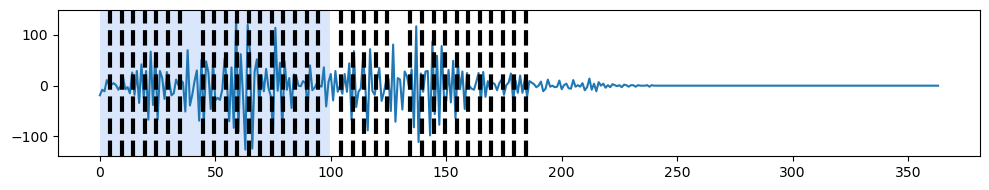

l2
2


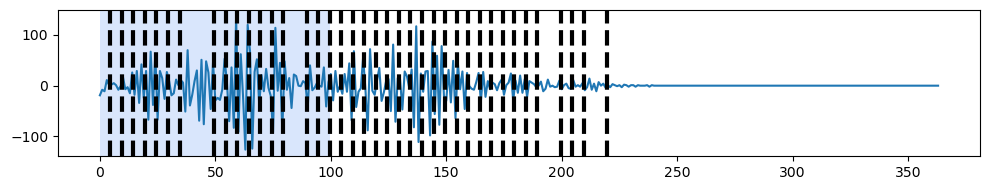

rbf
2


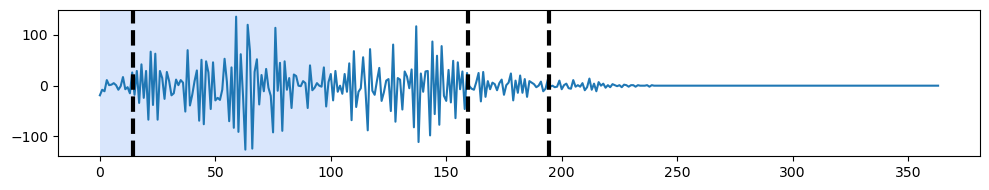

l1
3


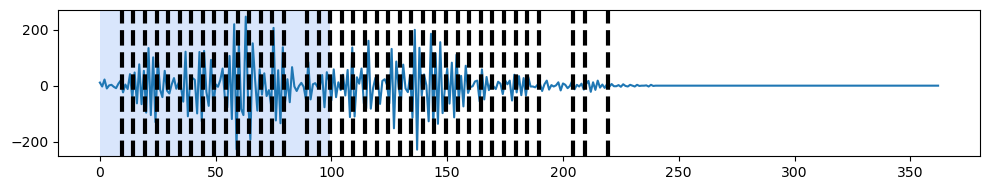

l2
3


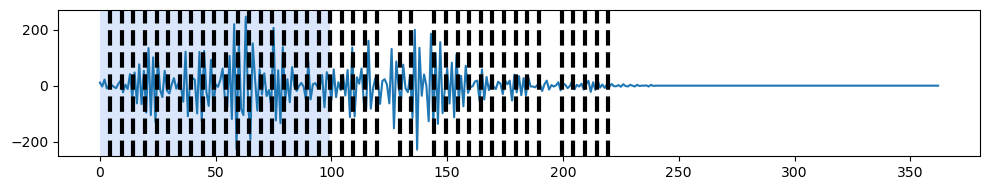

rbf
3


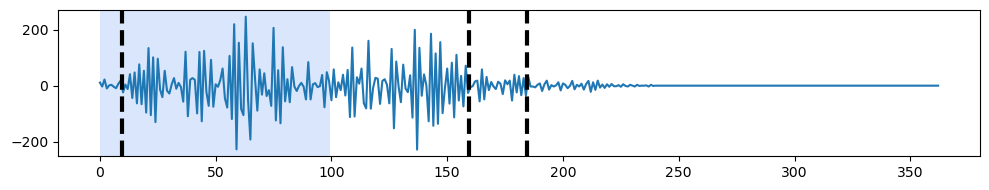

l1
4


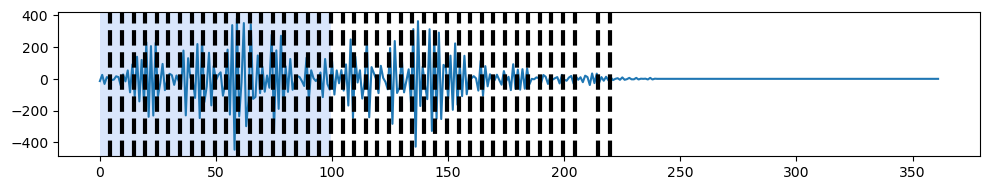

l2
4


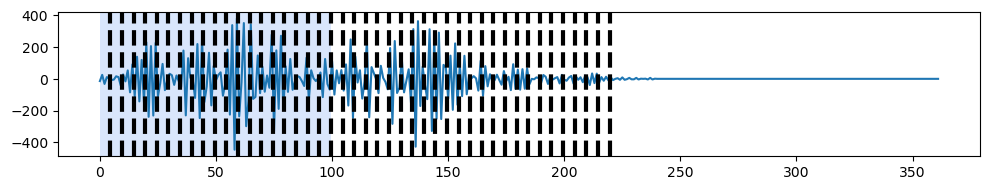

rbf
4


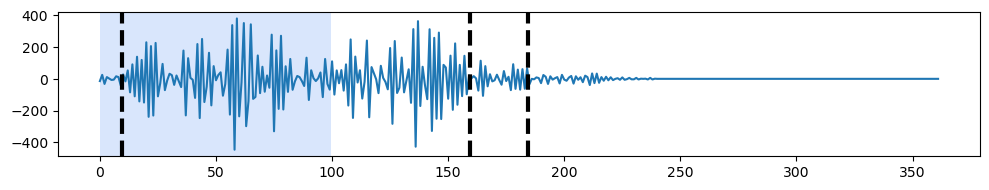

In [264]:
models = ["l1", "l2", "rbf"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Pelt(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(pen=3)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l2
0


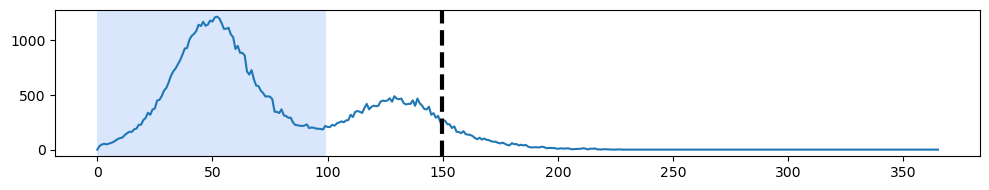

l1
0


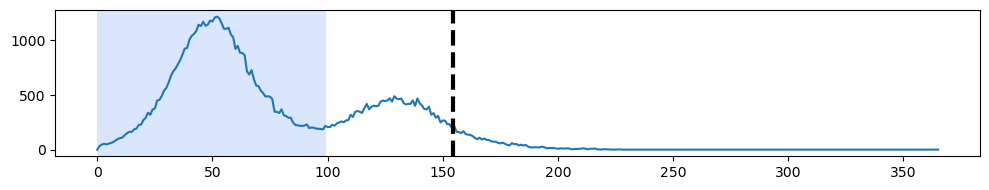

rbf
0


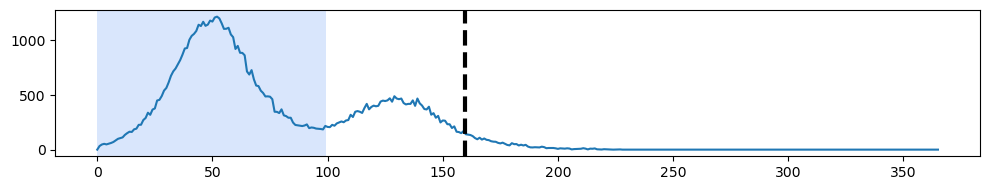

normal
0


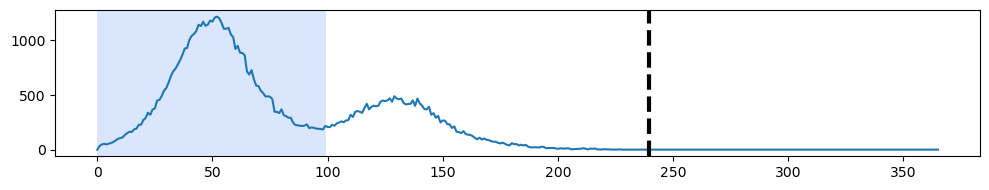

ar
0


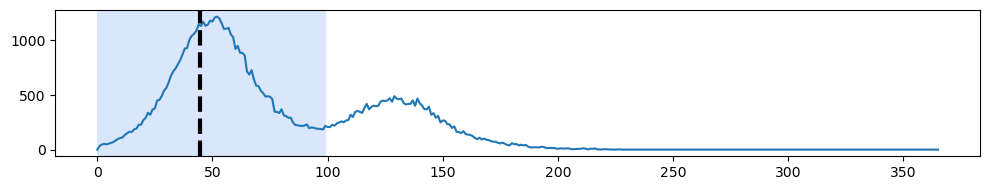

l2
1


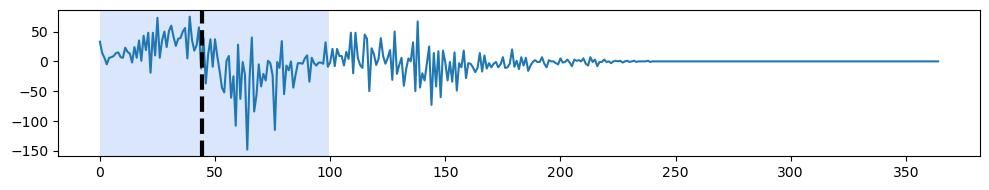

l1
1


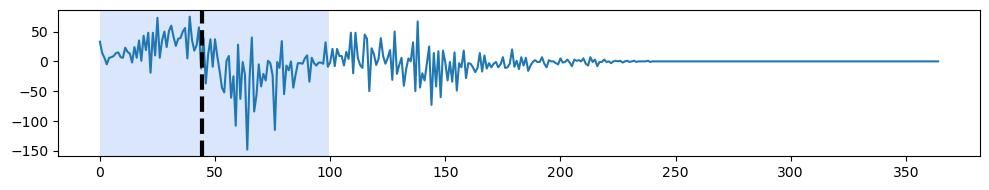

rbf
1


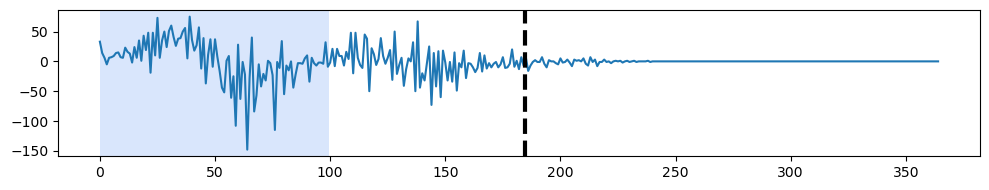

normal
1


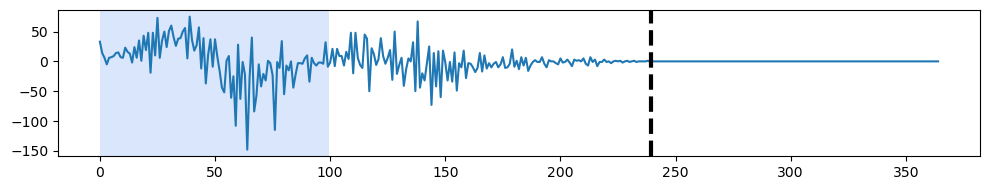

ar
1


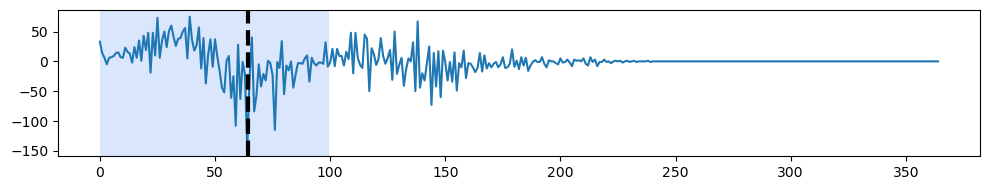

l2
2


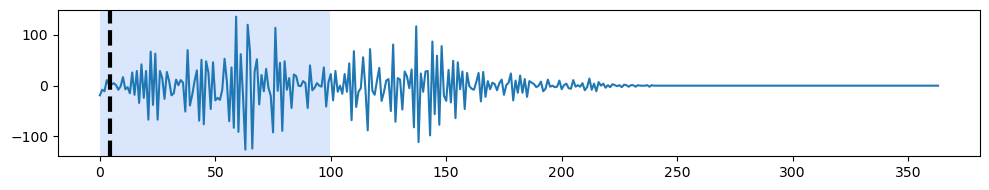

l1
2


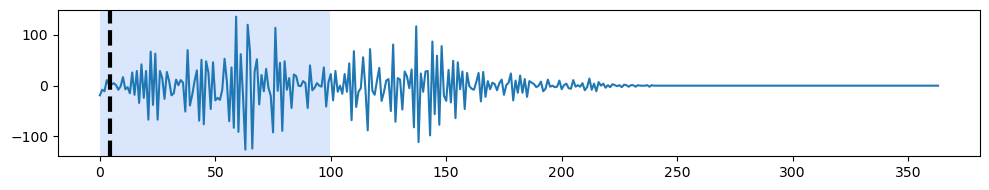

rbf
2


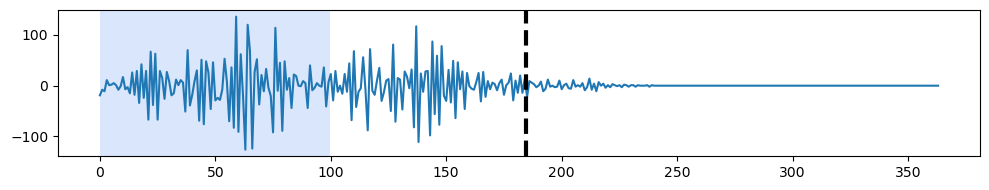

normal
2


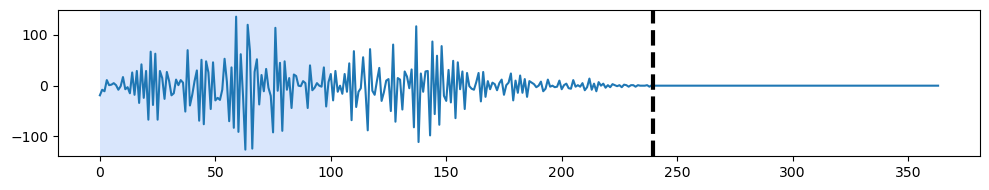

ar
2


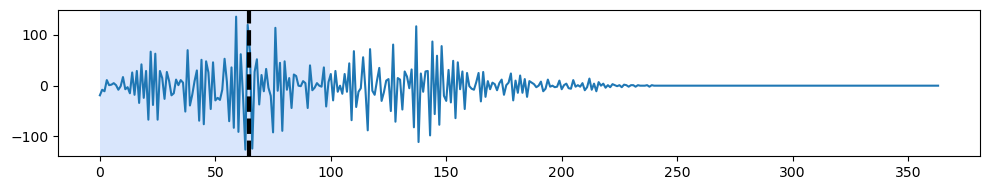

l2
3


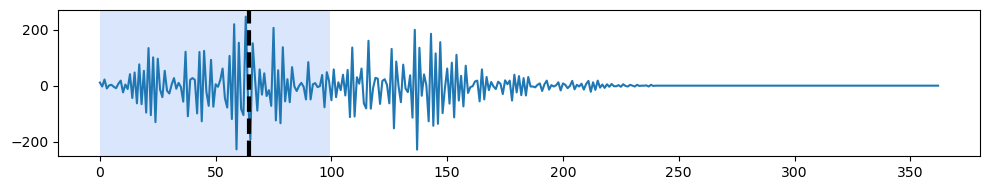

l1
3


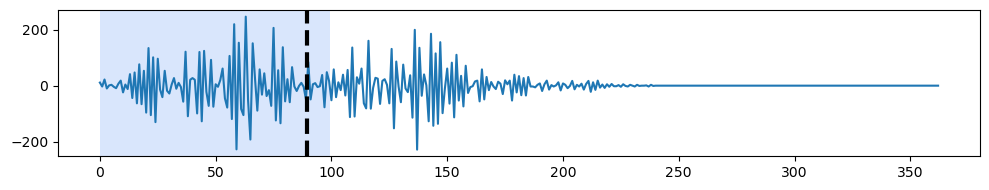

rbf
3


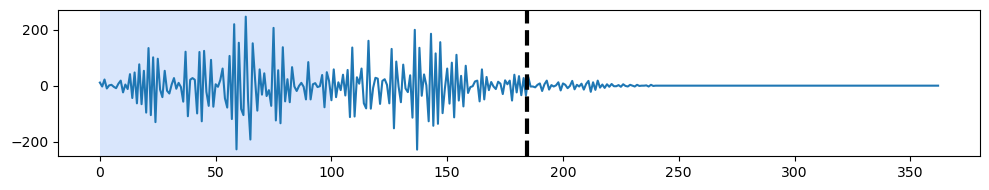

normal
3


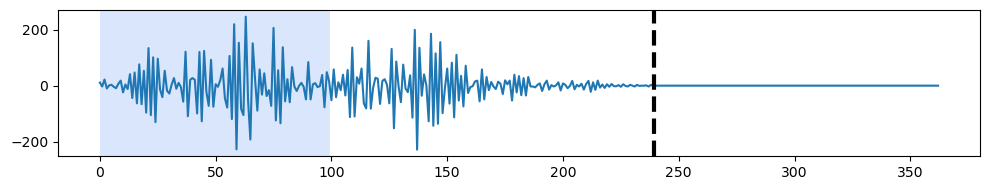

ar
3


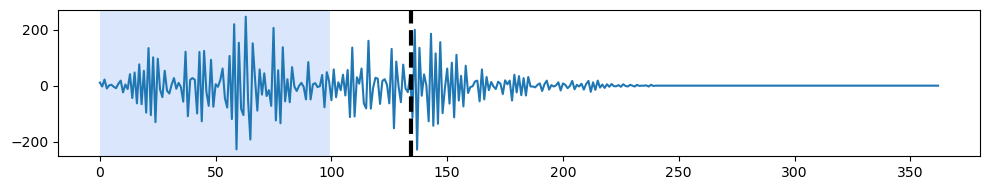

l2
4


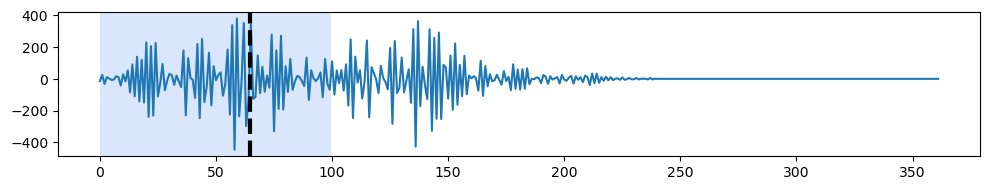

l1
4


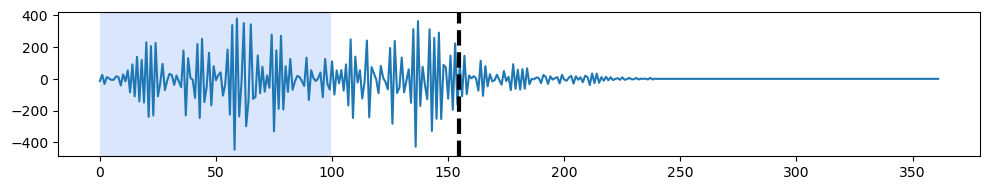

rbf
4


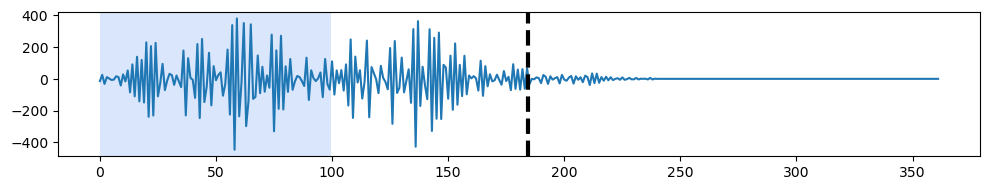

normal
4


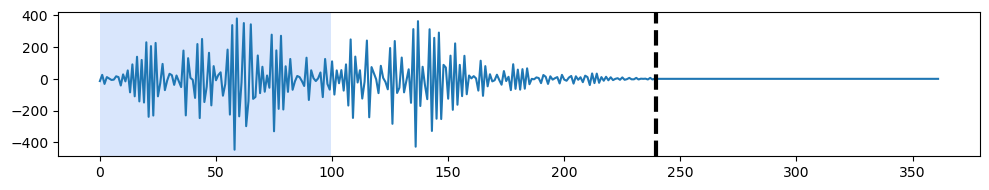

ar
4


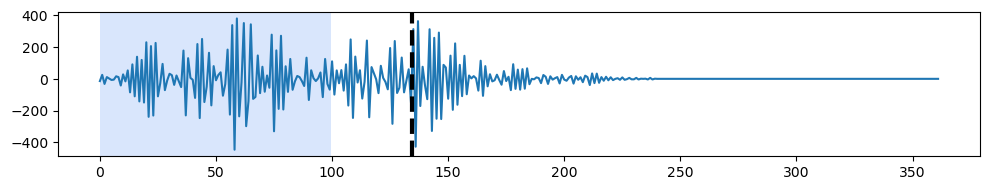

In [265]:
models = ["l2", "l1", "rbf", "normal", "ar"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Binseg(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l2
0


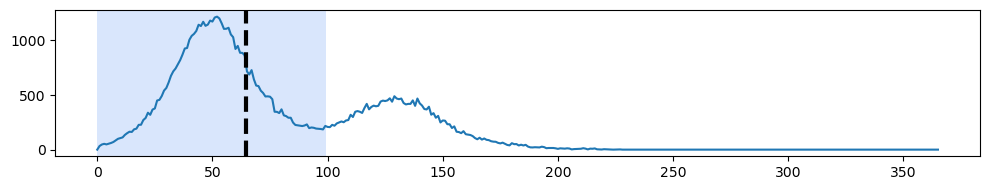

l1
0


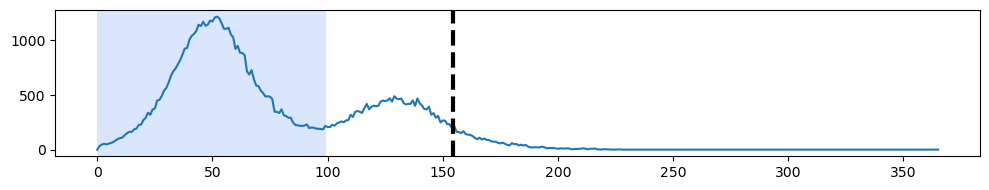

rbf
0


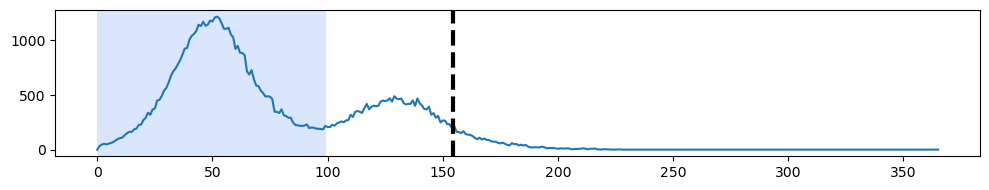

normal
0


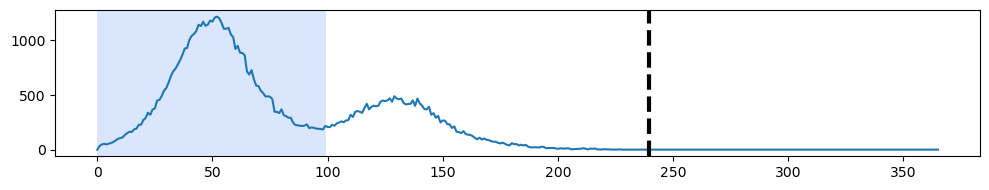

ar
0


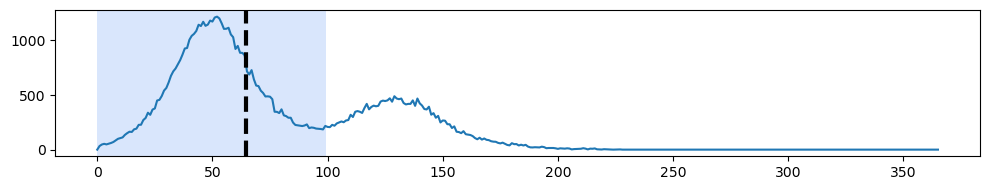

l2
1


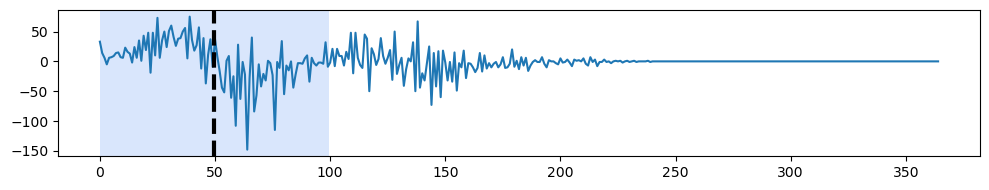

l1
1


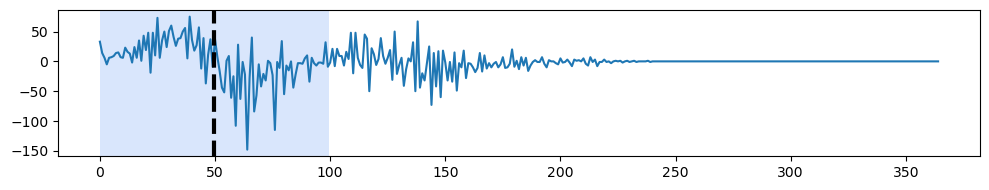

rbf
1


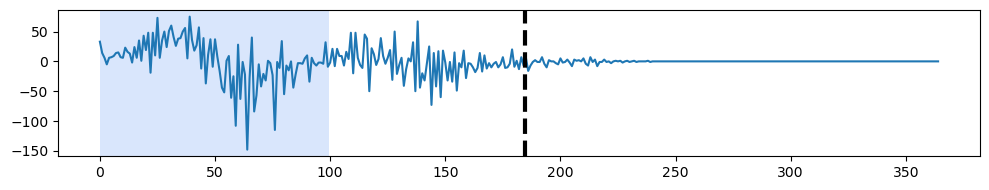

normal
1


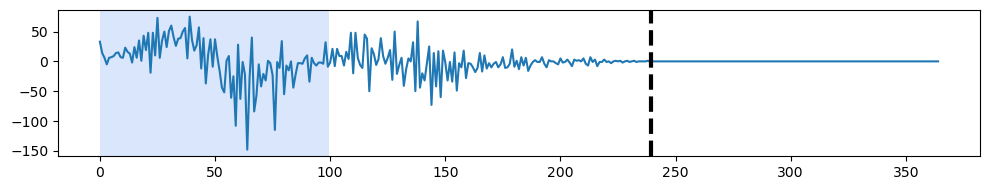

ar
1


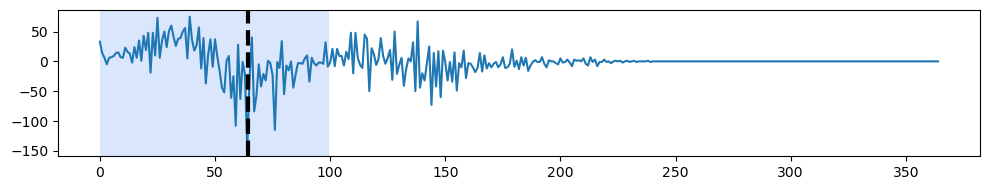

l2
2


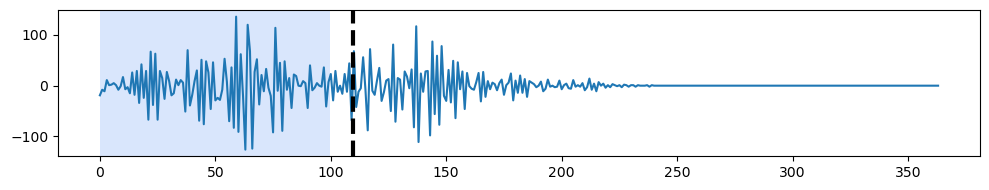

l1
2


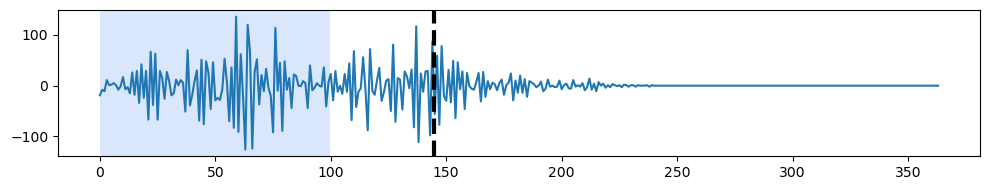

rbf
2


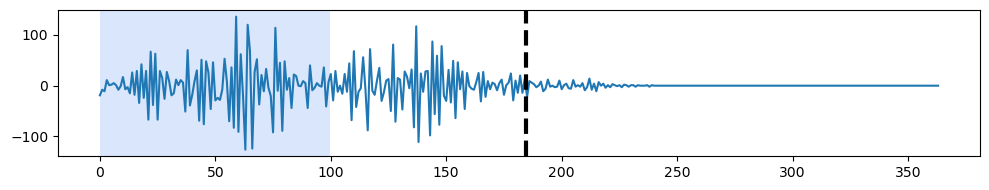

normal
2


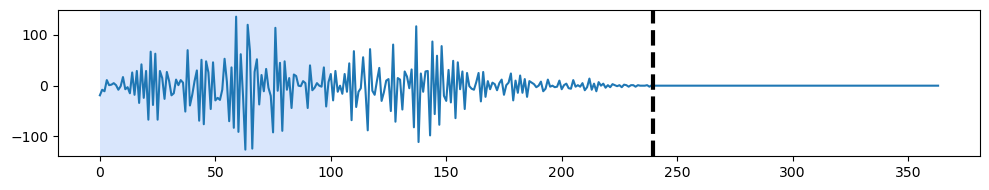

ar
2


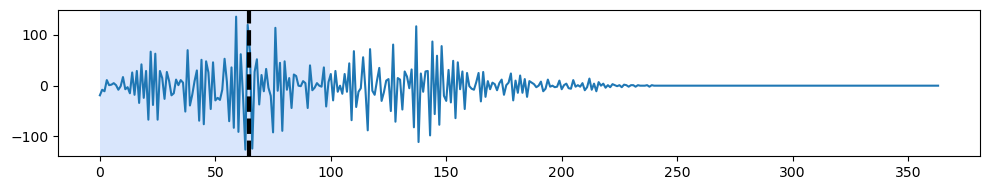

l2
3


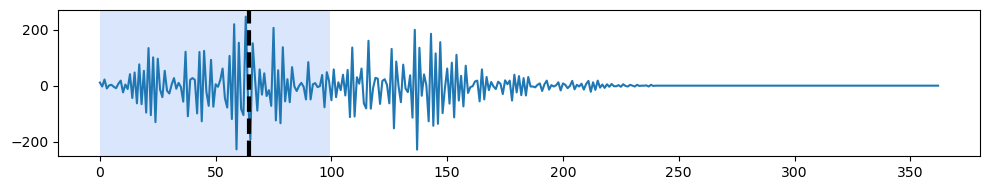

l1
3


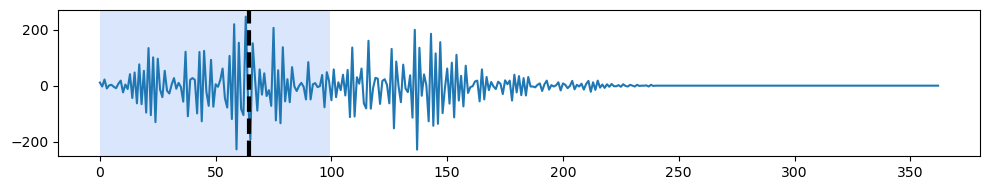

rbf
3


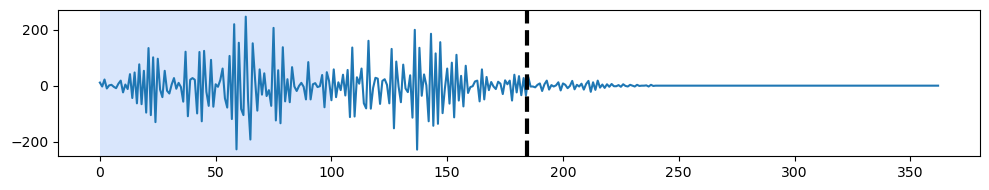

normal
3


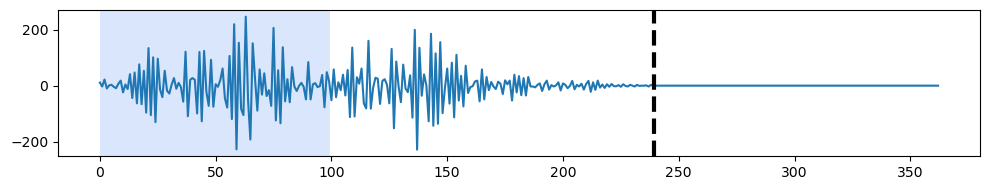

ar
3


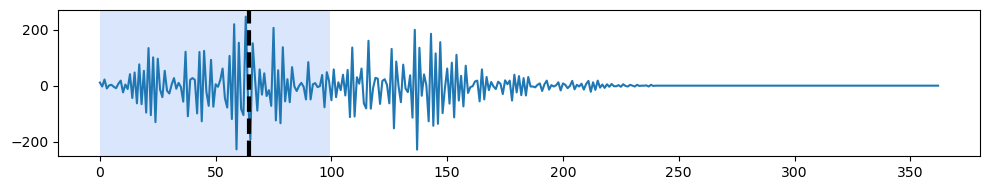

l2
4


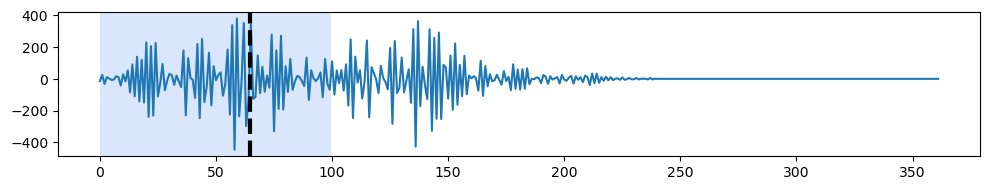

l1
4


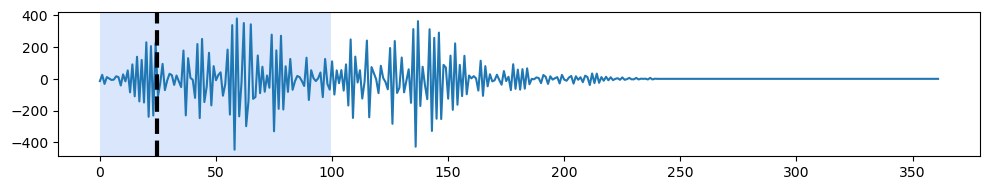

rbf
4


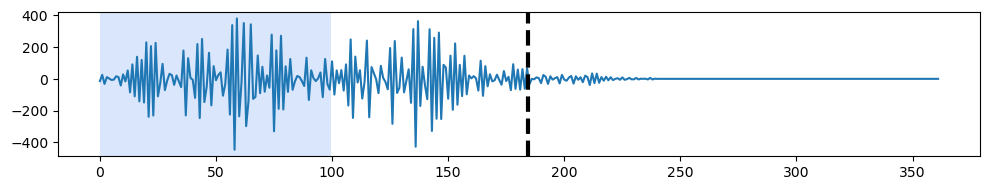

normal
4


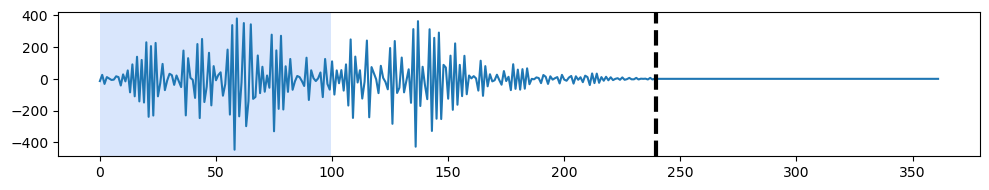

ar
4


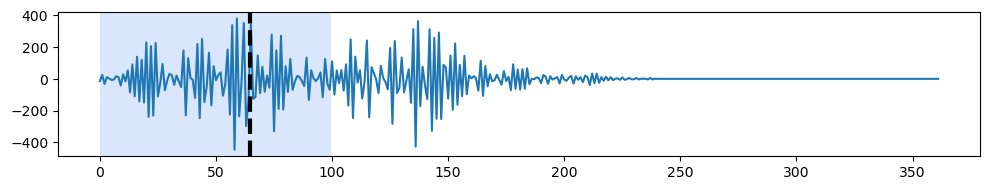

In [266]:
models = ["l2", "l1", "rbf", "normal", "ar"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.BottomUp(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l2
0


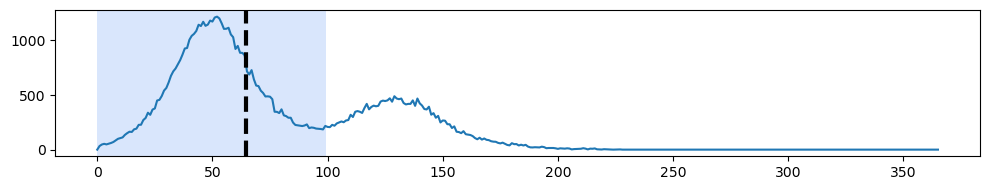

l1
0


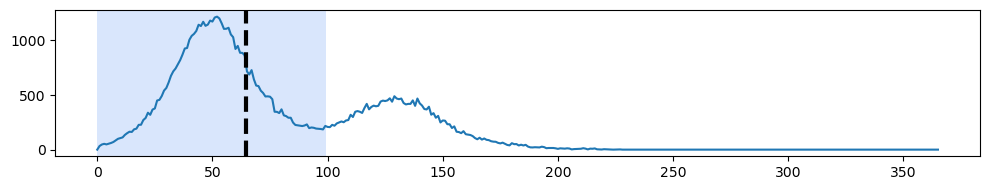

rbf
0


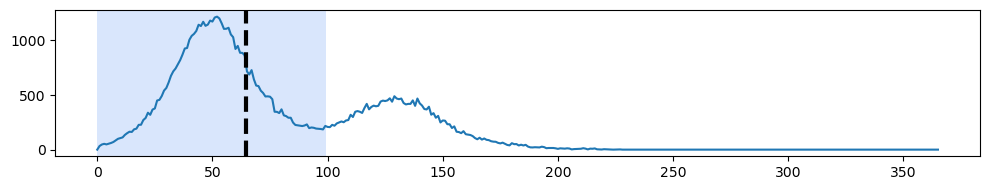

normal
0


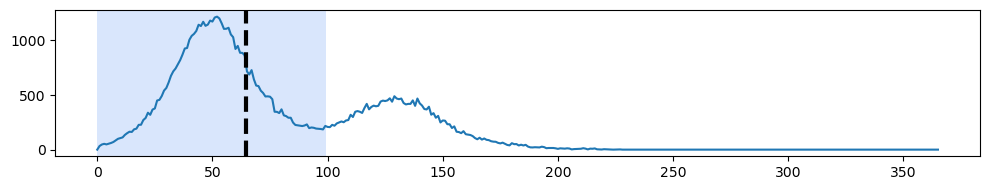

l2
1


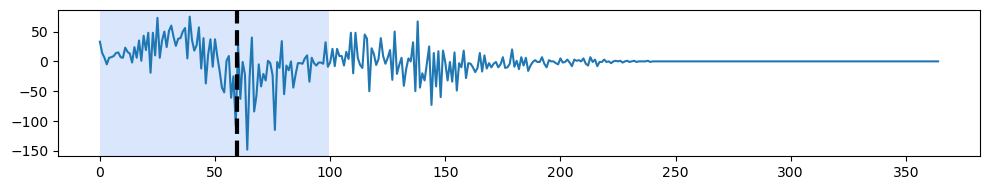

l1
1


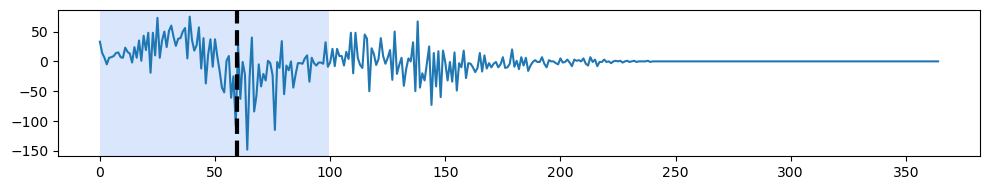

rbf
1


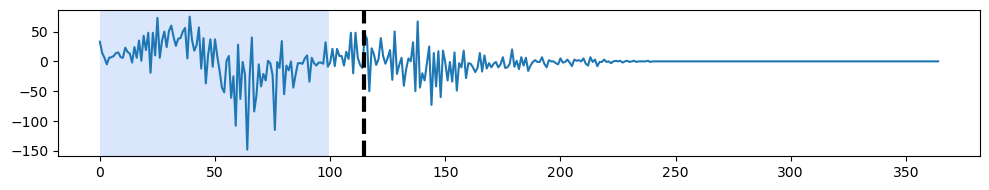

normal
1


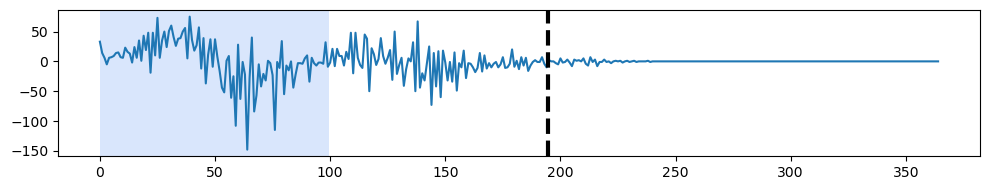

l2
2


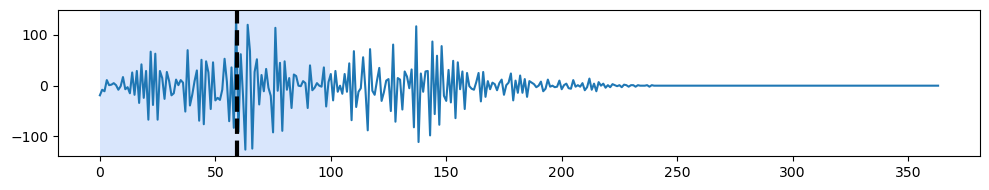

l1
2


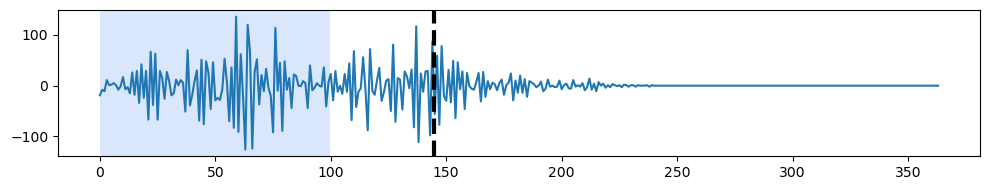

rbf
2


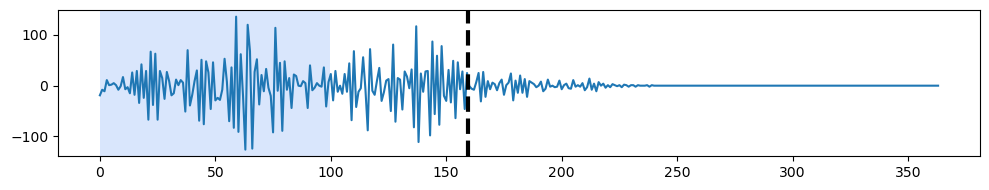

normal
2


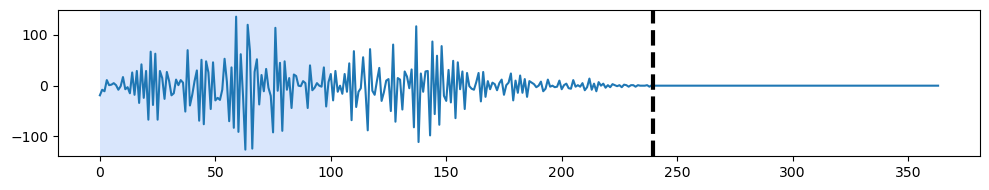

l2
3


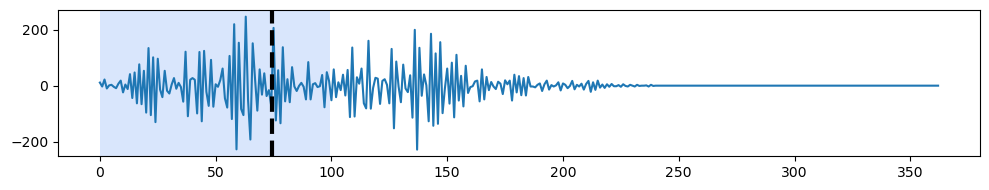

l1
3


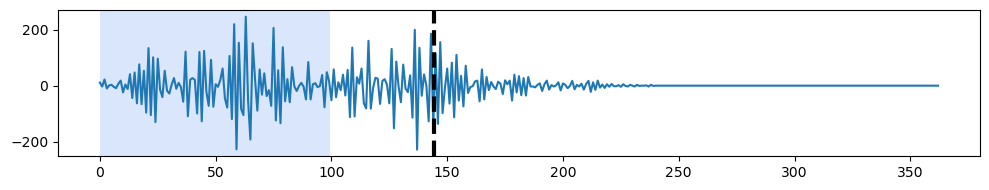

rbf
3


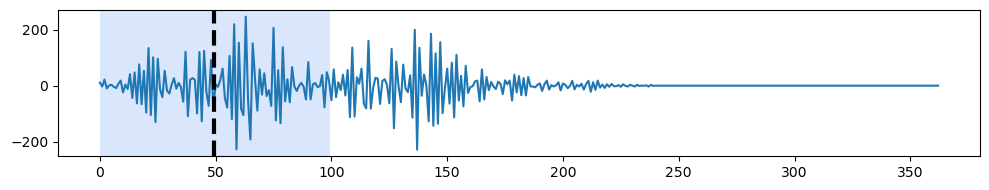

normal
3


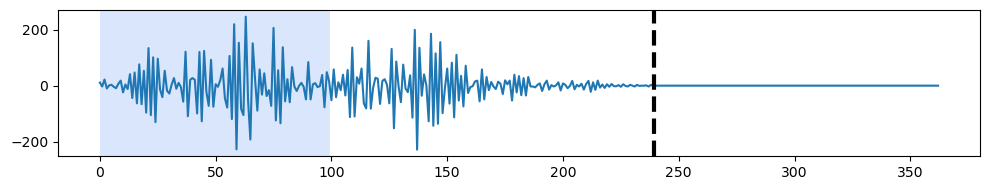

l2
4


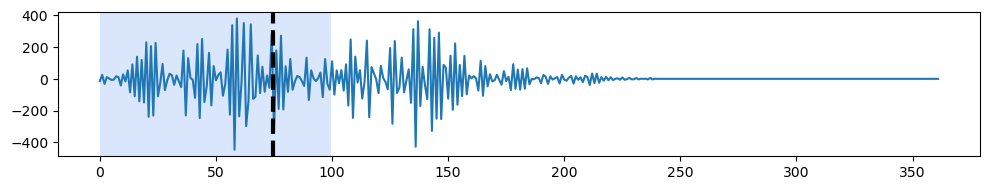

l1
4


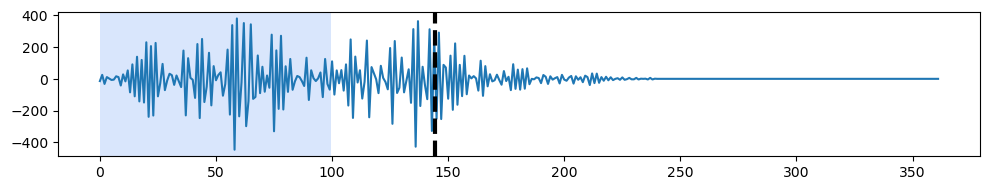

rbf
4


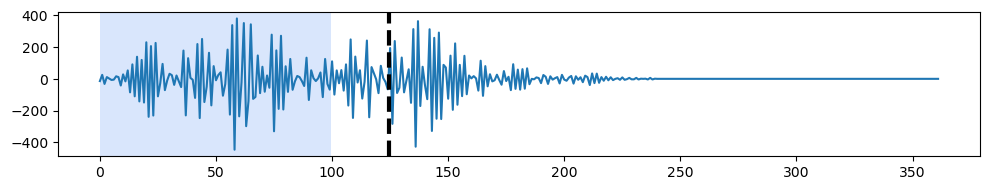

normal
4


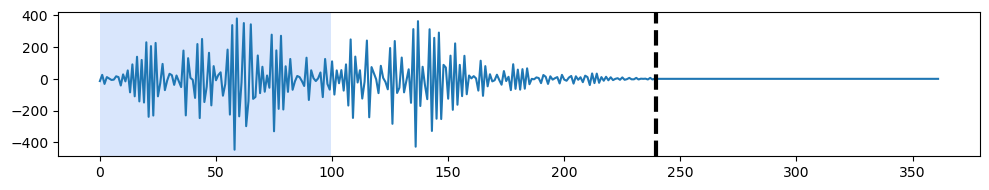

In [269]:
models = ["l2", "l1", "rbf", "normal"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Window(width=7, model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

## No time varying R

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
import pymc as pm
import arviz as az
import sunode
import sunode.wrappers.as_aesara
import datetime
import shelve
from datetime import datetime as dt
import time
 
# -------- Usage --------#
# covid_obj = COVID_data('US', Population=328.2e6)
# covid_obj.get_dates(data_begin='7/11/20', data_end='7/20/20')
# sir_model = SIR_model(covid_obj)
# likelihood = {'distribution': 'lognormal', 'sigma': 2}
# prior= {'lam': 0.4, 'mu': 1/8, lambda_std', 0.5 'mu_std': 0.5 }
# sir_model.run_SIR_model(n_samples=20, n_tune=10, likelihood=likelihood)
np.random.seed(0)
 
class COVID_data():
 
    def __init__(self, country='US', Population = 328.2e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        path_to_save = ''
 
        # ------------------------- Country for inference -------------------
 
        self.country = country
        self.N = Population   # Population of the country
                         # Germany - 83.7e6
                         # US - 328.2e6
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin  #Take the data until yesterday
        self.data_end = data_end
        self.num_days_to_predict = 14
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_country = confirmed_cases.loc[confirmed_cases["Country/Region"] == country]
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print("------------ Cases for selected period ----------- ",self.cases_obs)
 
        date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == self.country, data_begin:data_end].columns[-1]
        month, day, year = map(int,date_data_end.split('/'))
        date_data_end = datetime.date(year+2000, month, day)
        date_today = date_data_end + datetime.timedelta(days=1)
        print("------------- Cases yesterday ({}): {} and day before yesterday: {} ------------".format(date_data_end.isoformat(), *self.cases_obs[:-3:-1]))
        self.num_days = len(self.cases_obs)
 
        day_before_start = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=-1)
        day_before_start_cases = np.array(self.cases_country.loc[:, day_before_start.strftime('%-m/%-d/%-y')])
        print("------------ Day before start and cases for that date ------------", day_before_start, day_before_start_cases)
        future_days_begin = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=1)
        future_days_end = future_days_begin + datetime.timedelta(days=self.num_days_to_predict)
        self.future_days_begin_s = future_days_begin.strftime('%-m/%-d/%-y')
        self.future_days_end_s = future_days_end.strftime('%-m/%-d/%-y')
        print("------------- Future date begin and end -------------",self.future_days_begin_s, self.future_days_end_s)
        self.future_days = np.array(self.cases_country.loc[:, self.future_days_begin_s : self.future_days_end_s])[0]
        print("------------- Future days cases ------------", self.future_days)
 
 
class SIR_model():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_non_normalized(self, y, t, p):
        ds = -p[0] * y[0] * y[1] /self.covid_data.N
        di = p[0] * y[0] * y[1] / self.covid_data.N  -  p[1] * y[1]
        return [ds, di]
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
 
        # SIR model
        self.sir_model_non_normalized = DifferentialEquation(
            func=self.SIR_non_normalized,
            times=self.time_range[1:],
            n_states=2,
            n_theta=2,
            t0=0) 
 
 
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam_mu = np.log(self.prior['lam']) + self.prior['lambda_std']**2
            mu_mu = np.log(self.prior['mu']) + self.prior['mu_std']**2
            lam = pm.Lognormal('lambda', lam_mu , self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', mu_mu, self.prior['mu_std'])           # 1.5, 1.5
 
            res, _, problem, solver, _, _ = sunode.wrappers.as_aesara.solve_ivp(
              y0={
              # The initial conditions of the ode. Each variable
              # needs to specify a theano or numpy variable and a shape.
              # This dict can be nested.
                  'S': (self.S_init, ()),
                  'I': (self.I_init, ()),},
              params={
              # Each parameter of the ode. sunode will only compute derivatives
              # with respect to theano variables. The shape needs to be specified
              # as well. It it infered automatically for numpy variables.
              # This dict can be nested.
                  'lam': (lam, ()),
                  'mu': (mu, ()),
                  '_dummy': (np.array(1.), ())},
              # A functions that computes the right-hand-side of the ode using
              # sympy variables.
              rhs=self.SIR_sunode,
              # The time points where we want to access the solution
              tvals=self.time_range,
              t0=self.time_range[0]
            )
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
 
            print('Problem',problem)
            print('Solver',solver)
 
            R = 1 - (res['I'] + res['S'])
            R0 = pm.Deterministic('R0',lam/mu)

            step = pm.Metropolis()
            trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4, cores=4)
            # data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(trace, round_to=2, point_estimate='mode')
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
        
        fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # Add title
        fig.update_layout(title_text='Curve and Rug Plot')
        fig.update_xaxes(range=[0,7])
            
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
        return(fig)
 
 
 
covid_obj = COVID_data('US', Population=328.2e6)
covid_obj.get_dates(data_begin='2/1/20', data_end='9/28/20')
sir_model = SIR_model_sunode(covid_obj)
likelihood = {'distribution': 'lognormal', 
              'sigma': 2}
prior = {'lam': 1.0, 
         'mu': 0.5, 
         'lambda_std': 1.0,
         'mu_std': 0.2 }
# fig1 = sir_model.run_SIR_model(n_samples=2000, n_tune=1000, likelihood=likelihood, prior=prior)
sir_model.run_SIR_model(n_samples=20, n_tune=1, likelihood=likelihood, prior=prior)

ModuleNotFoundError: ignored